In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import rasterio
from rasterio.features import rasterize
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

The raw data used for this analysis was available in different units - per dwellings and per buildings. To deal with this uncertainty, the data had to be converted into the same unit. There were two different approaches used. 

## Approach 1: convert data on number of dwellings to number of disaggregated buildings.

In [2]:
import pandas as pd

# ---------------------------
# SSB 03175 – Building-Level Data Cleaner
# ---------------------------
class SSB03175DataCleaner:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_and_clean_data(self):
        df = pd.read_excel(self.file_path, header=None)
        df = df.drop(index=range(4))  # Remove initial metadata rows
        df = df.drop(index=range(366, 561), errors='ignore')  # Drop excessive rows
        df.iloc[0, 0] = "kommunenum"
        df.columns = df.iloc[0]
        df = df.drop(df.index[0]).reset_index(drop=True)
        df = df.dropna(how='all')
        exclude_munis = [
            'K-21-22 Svalbard and Jan Mayen',
            'K-23 Continental shelf',
            'K-Rest Divided municalities and unknown'
        ]
        df = df[~df['kommunenum'].isin(exclude_munis)]
        return df

# ---------------------------
# SSB 06266 – Dwelling-Level Data Cleaner
# ---------------------------
class SSB06266DataCleaner:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_and_clean_data(self):
        df = pd.read_excel(self.file_path, header=None)
        df.iloc[4, 1] = "kommunenum"
        df = df.drop(df.index[:4])
        df.columns = df.iloc[0]
        df = df.drop(df.index[0]).reset_index(drop=True)
        df = df.drop(df.columns[0], axis=1)
        df = df.dropna(how='all')
        exclude_vals = [
            'K-21-22 Svalbard and Jan Mayen',
            'K-23 Continental shelf',
            'K-Rest Divided municalities and unknown'
        ]
        df = df[~df['kommunenum'].isin(exclude_vals)]
        self.clean_column_names(df)
        return df

    def clean_column_names(self, df):
        df.columns = df.columns.str.replace("2021 and after", "2021", regex=False)
        df.columns = df.columns.str.replace('-', '_')
        df.columns.values[1:14] = ['Detached house_' + col for col in df.columns[1:14]]
        df.columns.values[14:27] = ['House with 2 dwellings_' + col for col in df.columns[14:27]]
        df.columns.values[27:40] = ['Row house, linked house and house with 3 dwellings or more_' + col
                                    for col in df.columns[27:40]]
        df.columns.values[40:53] = ['Multi-dwelling building_' + col for col in df.columns[40:53]]
        df.columns.values[53:] = ['Residence for communities_' + col for col in df.columns[53:]]
        return df

# ---------------------------
# Calculator: Sum Dwelling Counts by Archetype
# ---------------------------
class BuildingDwellingCalculator:
    def __init__(self, dwellings_df):
        self.data = dwellings_df

    def calculate_sums_by_category(self):
        summary = pd.DataFrame()
        summary['kommunenum'] = self.data['kommunenum'].values
        summary['Detached house'] = self.data.filter(like='Detached house_').sum(axis=1)
        summary['House with 2 dwellings'] = self.data.filter(like='House with 2 dwellings_').sum(axis=1)
        summary['Row house, linked house and house with 3 dwellings or more'] = \
            self.data.filter(like='Row house, linked house and house with 3 dwellings or more_').sum(axis=1)
        summary['Multi-dwelling building'] = self.data.filter(like='Multi-dwelling building_').sum(axis=1)
        summary['Residence for communities'] = self.data.filter(like='Residence for communities_').sum(axis=1)
        return summary

# ---------------------------
# Calculator: Dwelling Count per Building
# ---------------------------
class DwellingsPerBuildingCalculator:
    def __init__(self, dwellings_total, buildings_df):
        self.dwellings_total = dwellings_total
        self.buildings_data = buildings_df

    def calculate_dwellings_per_building(self):
        ratio_df = pd.DataFrame()
        ratio_df['kommunenum'] = self.dwellings_total['kommunenum'].values
        buildings_nonzero = self.buildings_data.replace(0, pd.NA)
        for category in self.dwellings_total.columns[1:]:
            ratio_df[category] = self.dwellings_total[category] / buildings_nonzero[category]
        return ratio_df

# ---------------------------
# Calculator: Disaggregated Building Data
# ---------------------------
class BuildingsDisaggregatedCalculator:
    def __init__(self, dwelling_data, dwellings_ratio):
        self.dwelling_data = dwelling_data
        self.dwellings_ratio = dwellings_ratio

    def calculate_disaggregated_buildings(self):
        disaggregated = self.dwelling_data[['kommunenum']].copy()
        for archetype in self.dwellings_ratio.columns[1:]:
            matching_columns = self.dwelling_data.filter(like=archetype).columns
            if not matching_columns.empty:
                for col in matching_columns:
                    denominator = self.dwellings_ratio[archetype]
                    disaggregated[col] = self.dwelling_data[col] / denominator.where(denominator != 0, 1)
        disaggregated = disaggregated.replace([float('inf'), -float('inf')], pd.NA).fillna(0)
        return disaggregated

# ---------------------------
# Function: Transform Building Data Columns
# ---------------------------
def transform_buildings_disaggregated(df):
    key = "kommunenum"
    filtered_cols = [col for col in df.columns if col == key or "Unknown" not in col]
    df = df[filtered_cols]
    # Rename archetypes for clarity.
    df.rename(columns=lambda col: col.replace("Detached house", "SFH")
              .replace("House with 2 dwellings", "MFH")
              .replace("Row house, linked house and house with 3 dwellings or more", "MFH")
              .replace("Multi-dwelling building", "AB")
              .replace("Residence for communities", "AB"), inplace=True)
    kommunenum_series = df[key]
    df_values = df.drop(columns=key)
    # Group the numeric columns by their archetype (i.e. sum columns sharing the same archetype)
    df_values = df_values.groupby(level=0, axis=1).sum()
    df_values.insert(0, key, kommunenum_series)
    return df_values

# ---------------------------
# Function: Rename Year Ranges
# ---------------------------
def rename_year_ranges(df):
    df.rename(
        columns=lambda col: (col if col == "kommunenum"
                             else col.replace("1946_1960", "1955")
                                     .replace("1941_1945", "1955")
                                     .replace("1921_1940", "1955")
                                     .replace("1901_1920", "1955")
                                     .replace("1900 and earlier", "1955")
                                     .replace("1961_1970", "1956_1970")),
        inplace=True
    )
    return df

# ---------------------------
# Function: Process Material Inventory Data
# ---------------------------
def process_material_inventory(file_path):
    mi_df = pd.read_excel(file_path)
    mi_df.drop(["Unnamed: 0", "Unit"], axis=1, inplace=True)
    archetypes_2011_2020 = mi_df[mi_df['Archetype'].str.endswith('2011_2020')]
    archetypes_2021 = archetypes_2011_2020.copy()
    archetypes_2021['Archetype'] = archetypes_2021['Archetype'].str.replace('2011_2020', '2021')
    mi_df = pd.concat([mi_df, archetypes_2021]).reset_index(drop=True)
    return mi_df

# ---------------------------
# Municipalities Converter (Reusable)
# ---------------------------
class MunicipalitiesConverter:
    def __init__(self, data):
        self.data = data

    def clean_municipalities(self):
        # Exclude unwanted municipality codes
        self.data = self.data[~self.data['kommunenum'].isin([
            'K-21-22 Svalbard and Jan Mayen',
            'K-23 Continental shelf',
            'K-Rest Divided municalities and unknown'
        ])]
        # Extract a standardized municipal code (characters 3–6)
        self.data['municipality_code'] = self.data['kommunenum'].str.slice(start=2, stop=6)
        self.data = self.data.drop(columns=['kommunenum'])
        self.data = self.data.rename(columns={'municipality_code': 'kommunenum'})
        self.data = self.data.set_index('kommunenum')
        return self.data

# ---------------------------
# Helper Function: Format Final Column Names
# ---------------------------
def format_output_columns(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

# ---------------------------
# Main Orchestration
# ---------------------------
def main_approach1():
    outputs = {}  # Dictionary to store intermediate datasets

    # File paths
    ssb03175_file = "/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_03175/ssb_03175_2024_raw.xlsx"
    ssb06266_file = "/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_06266/ssb_06266_2024_full.xlsx"
    material_inventory_file = "/Users/dolgayamaria/Thesis/Practical Part/Data/mi_no_updated.xlsx"

    # ---------------------------
    # Load and clean building-level data (SSB 03175)
    # ---------------------------
    building_cleaner = SSB03175DataCleaner(ssb03175_file)
    cleaned_buildings_df = building_cleaner.load_and_clean_data()
    outputs["cleaned_buildings_df"] = cleaned_buildings_df.copy()
    
    # ---------------------------
    # Load and clean dwelling-level data (SSB 06266)
    # ---------------------------
    dwellings_cleaner = SSB06266DataCleaner(ssb06266_file)
    dwellings_df = dwellings_cleaner.load_and_clean_data()
    outputs["dwellings_df"] = dwellings_df.copy()

    # ---------------------------
    # Calculate summed dwelling counts by archetype
    # ---------------------------
    dwelling_calculator = BuildingDwellingCalculator(dwellings_df)
    dwellings_total = dwelling_calculator.calculate_sums_by_category()
    outputs["dwellings_total"] = dwellings_total.copy()

    # ---------------------------
    # Calculate dwellings per building (ratio)
    # ---------------------------
    ratio_calculator = DwellingsPerBuildingCalculator(dwellings_total, cleaned_buildings_df)
    dwellings_ratio = ratio_calculator.calculate_dwellings_per_building()
    outputs["dwellings_ratio"] = dwellings_ratio.copy()

    # ---------------------------
    # Disaggregate building-level data
    # ---------------------------
    disaggregator = BuildingsDisaggregatedCalculator(dwellings_df, dwellings_ratio)
    buildings_disaggregated = disaggregator.calculate_disaggregated_buildings()
    outputs["buildings_disaggregated"] = buildings_disaggregated.copy()

    # ---------------------------
    # Transform and rename building data columns
    # ---------------------------
    buildings_transformed = transform_buildings_disaggregated(buildings_disaggregated)
    buildings_transformed = rename_year_ranges(buildings_transformed)
    outputs["buildings_transformed"] = buildings_transformed.copy()

    # ---------------------------
    # Standardize municipality identifiers
    # ---------------------------
    municipality_converter = MunicipalitiesConverter(buildings_transformed)
    buildings_with_municipalities = municipality_converter.clean_municipalities()
    outputs["buildings_with_municipalities"] = buildings_with_municipalities.copy()

    # ---------------------------
    # Melt the building data from wide to long format
    # ---------------------------
    buildings_melted = buildings_with_municipalities.reset_index().melt(
        id_vars='kommunenum', var_name='Archetype', value_name='building_count'
    )
    outputs["buildings_melted"] = buildings_melted.copy()

    # Group the melted data by municipality and archetype (summing building counts).
    buildings_melted_grouped = buildings_melted.groupby(['kommunenum', 'Archetype'], as_index=False)['building_count'].sum()
    outputs["buildings_melted_grouped"] = buildings_melted_grouped.copy()

    # ---------------------------
    # Process material inventory data.
    # ---------------------------
    material_inventory_data = process_material_inventory(material_inventory_file)
    outputs["material_inventory_data"] = material_inventory_data.copy()

    # ---------------------------
    # Merge building counts with material inventory data & calculate material stocks.
    # ---------------------------
    buildings_mi_merged = pd.merge(buildings_melted_grouped, material_inventory_data, on='Archetype')
    buildings_mi_merged['total_material_amounts'] = buildings_mi_merged['building_count'] * buildings_mi_merged['Value']
    buildings_mi_merged = format_output_columns(buildings_mi_merged)
    outputs["buildings_mi_merged"] = buildings_mi_merged.copy()


    # Save the final output as well.
    outputs["final_output"] = buildings_mi_merged.copy()
    return outputs

if __name__ == "__main__":
    # Run your Approach 1 main function that returns a dictionary of intermediate datasets.
    results_approach1 = main_approach1()

    # Create separate DataFrames from the dictionary using the keys list.
    cleaned_buildings_df      = results_approach1["cleaned_buildings_df"]
    dwellings_df              = results_approach1["dwellings_df"]
    dwellings_total           = results_approach1["dwellings_total"]
    dwellings_ratio           = results_approach1["dwellings_ratio"]
    buildings_disaggregated   = results_approach1["buildings_disaggregated"]
    buildings_transformed     = results_approach1["buildings_transformed"]
    buildings_with_municipalities = results_approach1["buildings_with_municipalities"]
    buildings_melted          = results_approach1["buildings_melted"]
    buildings_melted_grouped  = results_approach1["buildings_melted_grouped"]
    material_inventory_df     = results_approach1["material_inventory_data"]
    buildings_mi_merged       = results_approach1["buildings_mi_merged"]
    mat_stock_approach1    = results_approach1["final_output"]

    # Now each key is a separate DataFrame. For example:
    print("cleaned_buildings_df:")
    print(cleaned_buildings_df.head(), "\n")

    print("dwellings_df:")
    print(dwellings_df.head(), "\n")

    print("final_output_approach1:")
    print(mat_stock_approach1.head(), "\n")




cleaned_buildings_df:
4          kommunenum Detached house House with 2 dwellings  \
0       K-3101 Halden           7703                   1569   
1         K-3103 Moss           8423                   1255   
2    K-3105 Sarpsborg          12594                   2516   
3  K-3107 Fredrikstad          18170                   3066   
4       K-3110 Hvaler           1978                    138   

4 Row house, linked house and house with 3 dwellings or more  \
0                                               1056           
1                                               2174           
2                                               2439           
3                                               3188           
4                                                 80           

4 Multi-dwelling building Residence for communities  
0                     217                        31  
1                     591                        23  
2                     353                        31 

/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_10994/1074831484.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=lambda col: col.replace("Detached house", "SFH")
/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_10994/1074831484.py:130: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_values = df_values.groupby(level=0, axis=1).sum()


## Approach 2

In [3]:
# ---------------------------
# SSB06266 – Dwelling-Level Data Cleaner
# ---------------------------
class SSB06266DataCleaner:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_and_clean_data(self):
        df = pd.read_excel(self.file_path, header=None)
        df.iloc[4, 1] = "kommunenum"
        df = df.drop(df.index[:4])
        df.columns = df.iloc[0]
        df = df.drop(df.index[0]).reset_index(drop=True)
        df = df.drop(df.columns[0], axis=1)
        df = df.dropna(how='all')
        exclude_vals = [
            'K-21-22 Svalbard and Jan Mayen',
            'K-23 Continental shelf',
            'K-Rest Divided municalities and unknown'
        ]
        df = df[~df['kommunenum'].isin(exclude_vals)]
        self.clean_column_names(df)
        return df

    def clean_column_names(self, df):
        df.columns = df.columns.str.replace("2021 and after", "2021", regex=False)
        df.columns = df.columns.str.replace('-', '_')
        df.columns.values[1:14] = ['Detached house_' + col for col in df.columns[1:14]]
        df.columns.values[14:27] = ['House with 2 dwellings_' + col for col in df.columns[14:27]]
        df.columns.values[27:40] = ['Row house, linked house and house with 3 dwellings or more_' + col 
                                    for col in df.columns[27:40]]
        df.columns.values[40:53] = ['Multi-dwelling building_' + col for col in df.columns[40:53]]
        df.columns.values[53:] = ['Residence for communities_' + col for col in df.columns[53:]]
        return df

# ---------------------------
# Process Heated Floor Data
# ---------------------------
def process_heated_floor_data(file_path):
    df = pd.read_excel(file_path)
    df = df.set_index(df.columns[0])
    df.reset_index(inplace=True)
    melted = df.melt(id_vars=df.columns[0], var_name="Year", value_name="Value")
    melted["Combined"] = melted[df.columns[0]] + "_" + melted["Year"]
    pivoted_df = melted.pivot_table(index=None, columns="Combined", values="Value")
    pivoted_df.reset_index(drop=True, inplace=True)
    pivoted_df.rename(
        columns=lambda col: col.replace("_1800", "1955")
                           .replace("1801_1955", "1955")
                           .replace("2021_2050", "2021"),
        inplace=True
    )
    pivoted_df = pivoted_df.groupby(axis=1, level=0).mean()
    return pivoted_df

# ---------------------------
# Prepare Dwelling Data
# ---------------------------
def prepare_dwelling_data(dw_df):
    exclude_substrings = ["Unknown"]
    filtered_columns = [col for col in dw_df.columns if not any(sub in col for sub in exclude_substrings)]
    dw_df = dw_df[filtered_columns]

    dw_df.rename(columns=lambda col: col.replace("Detached house", "SFH")
                 .replace("House with 2 dwellings", "TH")
                 .replace("Row house, linked house and house with 3 dwellings or more", "TH")
                 .replace("Multi-dwelling building", "MFH")
                 .replace("Residence for communities", "MFH"), inplace=True)
    
    dw_df = dw_df.groupby(axis=1, level=0).sum()

    dw_df.rename(columns=lambda col: col.replace("1946_1960", "1955")
                 .replace("1941_1945", "1955")
                 .replace("1921_1940", "1955")
                 .replace("1901_1920", "1955")
                 .replace("1900 and earlier", "1955")
                 .replace("1961_1970", "1956_1970"), inplace=True)
    
    dw_df = dw_df.groupby(axis=1, level=0).sum()
    return dw_df

# ---------------------------
# Compute Total Heated Floor Area
# ---------------------------
def compute_heated_floor_area(dw_df, floor_area_df):
    av_broadcasted = pd.concat([floor_area_df] * len(dw_df), ignore_index=True)
    dw_numeric = dw_df.loc[:, dw_df.columns != 'kommunenum']
    av_numeric = av_broadcasted.loc[:, av_broadcasted.columns != 'Combined']
    
    dw_numeric = dw_numeric[av_numeric.columns]
    result_numeric = dw_numeric * av_numeric
    total_heated_area = pd.concat([dw_df[['kommunenum']], result_numeric], axis=1)

    total_heated_area.rename(columns=lambda col: col.replace("MFH", "AB").replace("TH", "MFH"), inplace=True)
    return total_heated_area

# ---------------------------
# Process Material Inventory Data
# ---------------------------
def process_material_inventory(file_path):
    mi_df = pd.read_excel(file_path)
    mi_df.drop(["Unnamed: 0", "Unit"], axis=1, inplace=True)
    archetypes_2011_2020 = mi_df[mi_df['Archetype'].str.endswith('2011_2020')]
    archetypes_2021 = archetypes_2011_2020.copy()
    archetypes_2021['Archetype'] = archetypes_2021['Archetype'].str.replace('2011_2020', '2021')
    mi_df = pd.concat([mi_df, archetypes_2021]).reset_index(drop=True)
    mi_df.rename(columns={"archetype": "Archetype"}, inplace=True)
    return mi_df

# ---------------------------
# Process Archetype Material Data
# ---------------------------
def process_archetype_material_data(archetype_area_file, material_inventory_df):
    archetype_df = pd.read_excel(archetype_area_file)

    # Ensure DB_Area exists, if not, rename the correct column
    if 'DB_Area' not in archetype_df.columns:
        possible = [col for col in archetype_df.columns if 'area' in col.lower()]
        if possible:
            archetype_df.rename(columns={possible[0]: 'DB_Area'}, inplace=True)
        else:
            raise KeyError("No 'DB_Area' column found or similar column to infer.")

    archetypes_2011_2020 = archetype_df[archetype_df['Archetype'].str.endswith('2011_2020')]
    archetypes_2021 = archetypes_2011_2020.copy()
    archetypes_2021['Archetype'] = archetypes_2021['Archetype'].str.replace('2011_2020', '2021')
    archetype_df = pd.concat([archetype_df, archetypes_2021]).reset_index(drop=True)
    
    merged_df = pd.merge(archetype_df, material_inventory_df, on='Archetype', how='inner')
    merged_df['Material_intensity'] = merged_df['Value'] / merged_df['DB_Area']
    return merged_df, archetype_df

# ---------------------------
# Helper Function
# ---------------------------
def format_output_columns(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

# ---------------------------
# Municipalities Converter
# ---------------------------
class MunicipalitiesConverter:
    def __init__(self, data):
        self.data = data

    def clean_municipalities(self):
        self.data = self.data[~self.data['kommunenum'].isin([
            'K-21-22 Svalbard and Jan Mayen',
            'K-23 Continental shelf',
            'K-Rest Divided municalities and unknown'
        ])]
        self.data['municipality_code'] = self.data['kommunenum'].str.slice(start=2, stop=6)
        self.data = self.data.drop(columns=['kommunenum'])
        self.data = self.data.rename(columns={'municipality_code': 'kommunenum'})
        self.data = self.data.set_index('kommunenum')
        return self.data

# ---------------------------
# Main Orchestration
# ---------------------------
def main_approach2():
    outputs = {}

    ssb06266_file = "/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_06266/ssb_06266_2024_full.xlsx"
    heated_floor_file = "/Users/dolgayamaria/Thesis/Practical Part/Data/Sandberg_2017_Table_B1.xlsx"
    archetype_area_file = "/Users/dolgayamaria/Thesis/Practical Part/Data/archetypes_areas.xlsx"
    material_inventory_file = "/Users/dolgayamaria/Thesis/Practical Part/Data/mi_no_updated.xlsx"

    dwellings_cleaner = SSB06266DataCleaner(ssb06266_file)
    dwellings_df = dwellings_cleaner.load_and_clean_data()
    outputs["dwellings_df"] = dwellings_df.copy()

    dwellings_prepared = prepare_dwelling_data(dwellings_df)
    outputs["dwellings_prepared"] = dwellings_prepared.copy()

    heated_floor_df = process_heated_floor_data(heated_floor_file)
    outputs["heated_floor_df"] = heated_floor_df.copy()

    total_heated_area = compute_heated_floor_area(dwellings_prepared, heated_floor_df)
    outputs["total_heated_area"] = total_heated_area.copy()

    municipality_converter = MunicipalitiesConverter(total_heated_area)
    total_heated_area_cleaned = municipality_converter.clean_municipalities()
    outputs["total_heated_area_cleaned"] = total_heated_area_cleaned.copy()

    total_heated_area_melted = total_heated_area_cleaned.reset_index().melt(
        id_vars='kommunenum', var_name='Archetype', value_name='Total Heated Area'
    )
    outputs["total_heated_area_melted"] = total_heated_area_melted.copy()

    material_inventory_data = process_material_inventory(material_inventory_file)
    outputs["material_inventory_data"] = material_inventory_data.copy()

    material_intensity_df, archetype_area_df = process_archetype_material_data(archetype_area_file, material_inventory_data)
    outputs["material_intensity_data"] = material_intensity_df.copy()
    outputs["archetype_area_data"] = archetype_area_df.copy()

    heated_area_mi_merged = pd.merge(
        total_heated_area_melted, material_intensity_df, on='Archetype'
    )
    heated_area_mi_merged['Total Material Amounts'] = (
        heated_area_mi_merged['Material_intensity'] * heated_area_mi_merged['Total Heated Area']
    )
    outputs["heated_area_mi_merged"] = heated_area_mi_merged.copy()

    heated_area_mi_merged = format_output_columns(heated_area_mi_merged)
    outputs["final_output"] = heated_area_mi_merged.copy()

    return outputs

# ---------------------------
# Execute Script
# ---------------------------
if __name__ == "__main__":
    results_approach2 = main_approach2()
    keys_list = [
        "dwellings_df", "dwellings_prepared", "heated_floor_df", "total_heated_area",
        "total_heated_area_cleaned", "total_heated_area_melted", "material_inventory_data",
        "archetype_area_data", "material_intensity_data", "heated_area_mi_merged", "final_output"
    ]
    dataset_list = [results_approach2[k] for k in keys_list]
    for name, df in zip(keys_list, dataset_list):
        print(f"--- {name} ---")
        print(df.head(), "\n")

    dwellings_df = results_approach2["dwellings_df"]
    dwellings_prepared = results_approach2["dwellings_prepared"]
    heated_floor_df = results_approach2["heated_floor_df"]
    total_heated_area = results_approach2["total_heated_area"]
    total_heated_area_cleaned = results_approach2["total_heated_area_cleaned"]
    total_heated_area_melted = results_approach2["total_heated_area_melted"]
    material_inventory_data = results_approach2["material_inventory_data"]
    archetype_area_df = results_approach2["archetype_area_data"]
    material_intensity_df = results_approach2["material_intensity_data"]
    heated_area_mi_merged = results_approach2["heated_area_mi_merged"]
    mat_stock_approach_2 = results_approach2["final_output"]


--- dwellings_df ---
4          kommunenum Detached house_1900 and earlier  \
0       K-3101 Halden                             599   
1         K-3103 Moss                             528   
2    K-3105 Sarpsborg                             761   
3  K-3107 Fredrikstad                            2171   
4       K-3110 Hvaler                             270   

4 Detached house_1901_1920 Detached house_1921_1940 Detached house_1941_1945  \
0                      420                      717                       27   
1                      392                      711                       36   
2                      785                     1202                       74   
3                     1242                     1409                       80   
4                      102                      100                        6   

4 Detached house_1946_1960 Detached house_1961_1970 Detached house_1971_1980  \
0                      906                     1119                     118

/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_10994/3238788622.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dw_df.rename(columns=lambda col: col.replace("Detached house", "SFH")
/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_10994/3238788622.py:71: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  dw_df = dw_df.groupby(axis=1, level=0).sum()
/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_10994/3238788622.py:80: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  dw_df = dw_df.groupby(axis=1, level=0).sum()
/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_10994/3238788622.py:54: FutureWarning: DataFrame.groupby with axis=1 is depreca

## "Other" dwellings 

In [4]:
# ------------------------------
# SSB Other Data Cleaner Class
# ------------------------------
class SSBOtherDataCleaner:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_and_clean_data(self):
        self.data = pd.read_excel(self.file_path, header=None)
        self.data = self.data.drop(index=range(4))
        self.data = self.data.drop(index=range(366, 567), errors='ignore')
        self.data = self.data.drop(columns=self.data.columns[0])
        self.data.iloc[0, 0] = "kommunenum"
        self.data.columns = self.data.iloc[0]
        self.data = self.data.drop(self.data.index[0]).reset_index(drop=True)
        self.data = self.data.dropna(how='all')
        self.data.columns = self.data.columns.str.replace('-', '_')
        self.data = self.data[~self.data['kommunenum'].isin([
            'K-21-22 Svalbard and Jan Mayen', 
            'K-23 Continental shelf', 
            'K-Rest Divided municalities and unknown'
        ])]
        self.data['municipality_code'] = self.data['kommunenum'].str.slice(start=2, stop=6)
        self.data = self.data.drop(columns=['kommunenum']).rename(columns={'municipality_code': 'kommunenum'})
        self.data = self.data.set_index('kommunenum')
        return self.data

# ------------------------------
# STEP 1: Load & Clean "OTHER" Data
# ------------------------------
ssb_other_cleaner = SSBOtherDataCleaner("/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_06266/06266_other.xlsx")
other_dwellings = ssb_other_cleaner.load_and_clean_data()

other_dwellings.rename(
    columns=lambda col: col.replace("1946_1960", "Other_1955")
                        .replace("1961_1970", "Other_1956_1970")
                        .replace("1971_1980", "Other_1971_1980")
                        .replace("1981_1990", "Other_1981_1990")
                        .replace("1991_2000", "Other_1991_2000")
                        .replace("2001_2010", "Other_2001_2010")
                        .replace("2011_2020", "Other_2011_2020")
                        .replace("2021 and after", "Other_2021"),
    inplace=True
)
other_dwellings.rename(
    columns=lambda col: col.replace("1941_1945", "Other_1955")
                        .replace("1921_1940", "Other_1955")
                        .replace("1901_1920", "Other_1955")
                        .replace("1900 and earlier", "Other_1955"),
    inplace=True
)
other_dwellings = other_dwellings.groupby(axis=1, level=0).sum()

# ------------------------------
# STEP 2: Load Spatial & Population Data
# ------------------------------
municipal_masks_2024 = gpd.read_file('/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_municipalities_masks/Kommuner 2024.shp')
pop_2024_1km = gpd.read_file("/Users/dolgayamaria/Thesis/Practical Part/Data/SSB_population_2024_1km/Befolkning 1km 2024.shp")
if municipal_masks_2024.crs != pop_2024_1km.crs:
    pop_2024_1km = pop_2024_1km.to_crs(municipal_masks_2024.crs)
pop_2024_1km_with_municipalities = gpd.sjoin(pop_2024_1km, municipal_masks_2024, how="inner", predicate="within")
population_by_municipality = pop_2024_1km_with_municipalities.groupby('kommunenum')['pop_tot'].sum().reset_index()
municipalities_with_population = municipal_masks_2024.merge(population_by_municipality, on="kommunenum", how="left")
pop_other = municipalities_with_population.merge(other_dwellings, on="kommunenum", how="inner")

# ------------------------------
# STEP 3: Merge with Dwelling Data via MunicipalitiesConverter
# ------------------------------
# Assume dwellings_prepared is already loaded and MunicipalitiesConverter is defined.
municipality_converter = MunicipalitiesConverter(dwellings_prepared)
dw_converted = municipality_converter.clean_municipalities()
dw_full_pop = pop_other.merge(dw_converted, on="kommunenum", how="inner")
dw_full_pop.rename(
    columns=lambda col: col.replace("MFH", "AB").replace("TH", "MFH"),
    inplace=True
)

# ------------------------------
# STEP 4: Compute Per Capita Values & Determine Closest Building Type
# ------------------------------
dw_full_pop["Other_per_capita"] = dw_full_pop[[col for col in dw_full_pop.columns if col.startswith("Other_")]].sum(axis=1) / dw_full_pop["pop_tot"]
dw_full_pop["SFH_per_capita"] = dw_full_pop[[col for col in dw_full_pop.columns if col.startswith("SFH_")]].sum(axis=1) / dw_full_pop["pop_tot"]
dw_full_pop["MFH_per_capita"] = dw_full_pop[[col for col in dw_full_pop.columns if col.startswith("MFH_")]].sum(axis=1) / dw_full_pop["pop_tot"]
dw_full_pop["AB_per_capita"] = dw_full_pop[[col for col in dw_full_pop.columns if col.startswith("AB_")]].sum(axis=1) / dw_full_pop["pop_tot"]
dw_full_pop["Closest_to"] = dw_full_pop[["SFH_per_capita", "MFH_per_capita", "AB_per_capita"]].sub(dw_full_pop["Other_per_capita"], axis=0).abs().idxmin(axis=1)
dw_other_incl = dw_full_pop.copy()

# ------------------------------
# STEP 5: Allocate "Other" Values to Building Types
# ------------------------------
for btype in ["AB", "SFH", "MFH"]:
    closest_rows = dw_other_incl["Closest_to"] == f"{btype}_per_capita"
    other_cols = [col for col in dw_other_incl.columns if col.startswith("Other_") and not col.endswith("_per_capita")]
    target_cols = [col for col in dw_other_incl.columns if col.startswith(f"{btype}_") and not col.endswith("_per_capita")]
    other_sorted = sorted(other_cols, key=lambda x: int(x.split("_")[1]))
    target_sorted = sorted(target_cols, key=lambda x: int(x.split("_")[1]))
    assert len(target_sorted) == len(other_sorted), f"Mismatch for {btype}"
    for t, o in zip(target_sorted, other_sorted):
        dw_other_incl.loc[closest_rows, t] += dw_other_incl.loc[closest_rows, o]
dw_other_incl.drop(columns=other_cols, inplace=True)
dw_other_incl = dw_other_incl.drop(['kommunenav', 'geometry', 'pop_tot', 'Unknown',
                                      'Other_per_capita', 'SFH_per_capita', 'MFH_per_capita',
                                      'AB_per_capita', 'Closest_to'], axis=1)

# ------------------------------
# STEP 6: Multiply by Average Heated Floor Area
# ------------------------------
heated_floor_df.rename(
    columns=lambda col: col.replace("MFH", "AB").replace("TH", "MFH"),
    inplace=True
)
av_broadcasted = pd.concat([heated_floor_df] * len(dw_other_incl), ignore_index=True)
dw_numeric = dw_other_incl.loc[:, dw_other_incl.columns != 'kommunenum']
av_numeric = av_broadcasted.loc[:, av_broadcasted.columns != 'Combined']
dw_numeric = dw_numeric[av_numeric.columns]
result_numeric = dw_numeric * av_numeric
total_heated_area = pd.concat([dw_other_incl[['kommunenum']], result_numeric], axis=1)
total_heated_area.set_index('kommunenum', inplace=True)
total_heated_area_melted = total_heated_area.reset_index().melt(id_vars='kommunenum', var_name='archetype', value_name='total_heated_area')

# ------------------------------
# STEP 7: Merge with Material Intensity Data & Compute Totals
# ------------------------------
total_heated_area_melted.columns = total_heated_area_melted.columns.str.lower().str.replace(' ', '_')
material_intensity_df.columns = material_intensity_df.columns.str.lower().str.replace(' ', '_')
heated_area_other_mi_merged = total_heated_area_melted.merge(material_intensity_df, on='archetype')
heated_area_other_mi_merged['total_material_amounts'] = heated_area_other_mi_merged['material_intensity'] * heated_area_other_mi_merged['total_heated_area']
heated_area_other_mi_merged.columns = heated_area_other_mi_merged.columns.str.lower().str.replace(' ', '_')



/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_10994/1616192361.py:53: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  other_dwellings = other_dwellings.groupby(axis=1, level=0).sum()


In [5]:
# Load datasets
old_data = mat_stock_approach_2.copy() # Without "other" dwellings
new_data = heated_area_other_mi_merged.copy()  # With "other" dwellings

# Summarize total material amounts
total_old = old_data.loc[old_data['material_type'] == 'TOTAL', 'total_material_amounts'].sum()
total_new = new_data.loc[new_data['material_type'] == 'TOTAL', 'total_material_amounts'].sum()

total_diff = total_new - total_old
percent_change = (total_diff / total_old) * 100

print(f"Total Material Amounts (Old): {total_old:.2f} kg")
print(f"Total Material Amounts (New): {total_new:.2f} kg")
print(f"Absolute Difference: {total_diff:.2f} kg, {total_diff / 1_000_000_000:.2f} Mt")
print(f"Percentage Change: {percent_change:.2f}%\n")

Total Material Amounts (Old): 258561924495.03 kg
Total Material Amounts (New): 264039497927.74 kg
Absolute Difference: 5477573432.71 kg, 5.48 Mt
Percentage Change: 2.12%



## Plots

In [49]:
def plot_by_archetype(old_data, new_data):
    old_data['Dataset'] = 'Without OTHER'
    new_data['Dataset'] = 'With OTHER'
    combined_data = pd.concat([old_data, new_data])
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 8))
    ax = sns.boxplot(x='archetype', y='total_material_amounts', hue='Dataset', 
                     data=combined_data, width=0.6)
    ax.set_yscale("log")
    ax.set_ylim(100, combined_data['total_material_amounts'].max() * 1.1)  # <--- Adjust lower limit
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Distribution of total material amounts by archetype', fontsize=14)
    plt.ylabel('Total material amounts', fontsize=13)
    plt.xlabel('')
    plt.legend(title='Dataset', loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


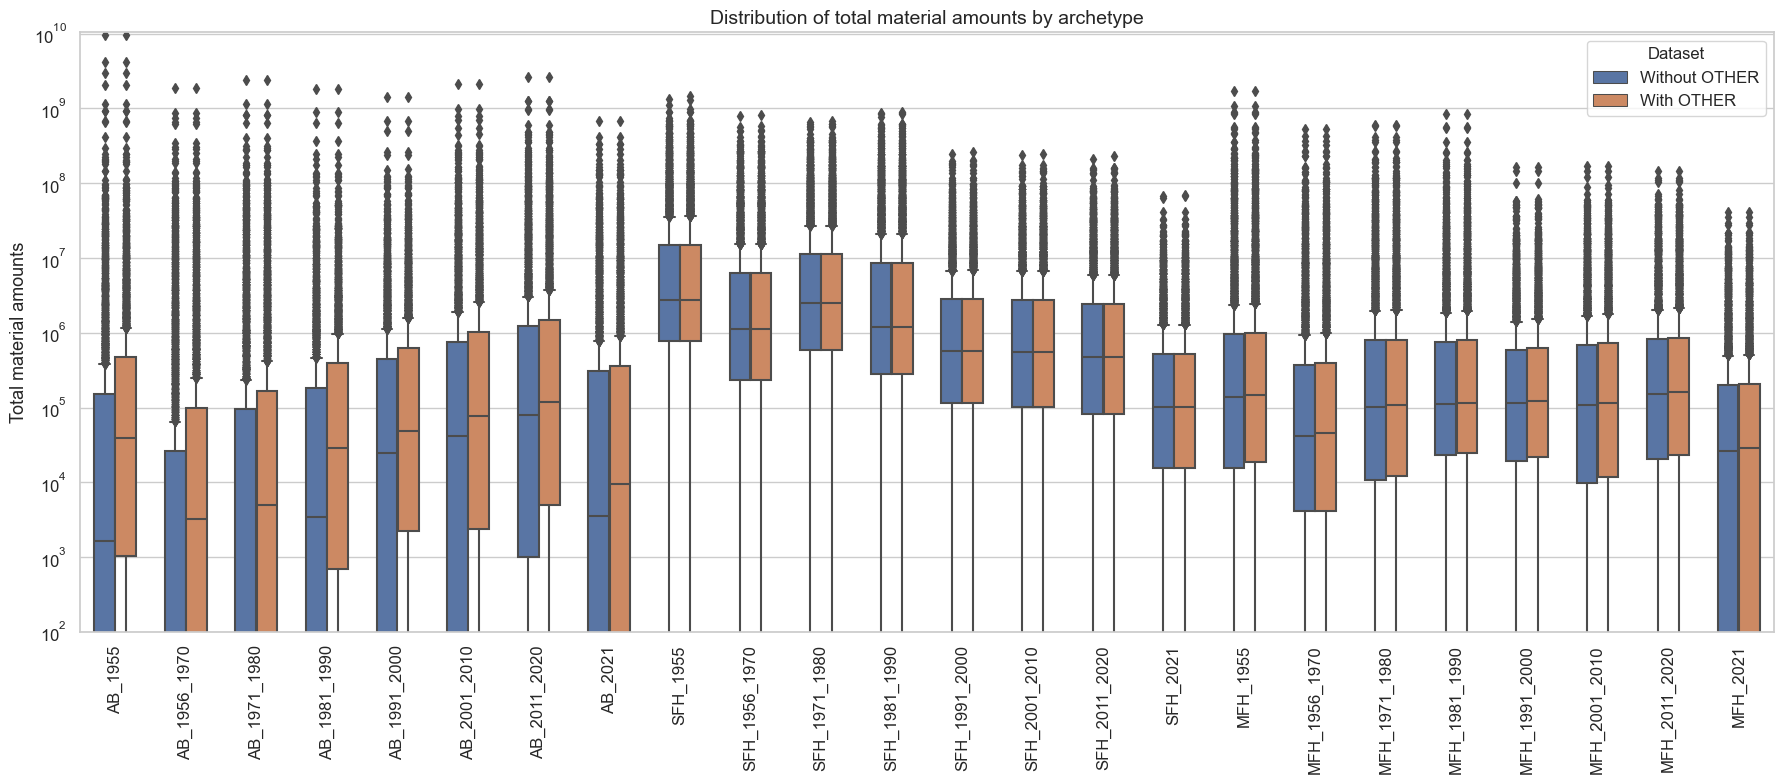

In [50]:
plot_by_archetype(old_data, new_data) # Skewed because the min is 0

In [51]:
# Standardize column names: lowercase and replace spaces with underscores
mat_stock_approach_2.columns = mat_stock_approach_2.columns.str.lower().str.replace(' ', '_')
municipalities_with_population.columns = municipalities_with_population.columns.str.lower().str.replace(' ', '_')


# Merge using lowercase column names
mat_intensity_pop_merge = pd.merge(
    mat_stock_approach_2,
    municipalities_with_population[['kommunenum','kommunenav','pop_tot']],
    on='kommunenum',
    how='left'
)

# Continue as normal
TOTAL_data = mat_intensity_pop_merge[mat_intensity_pop_merge["material_type"] == "TOTAL"]
TOTAL_data = TOTAL_data.drop(columns=["db_area", "db_basement", "db_total"])

summed_data = TOTAL_data.groupby(['kommunenum'], as_index=False).agg({
    'total_material_amounts': 'sum',
    'pop_tot': 'first'
})

summed_data["ms_per_capita"] = summed_data["total_material_amounts"] / summed_data["pop_tot"]


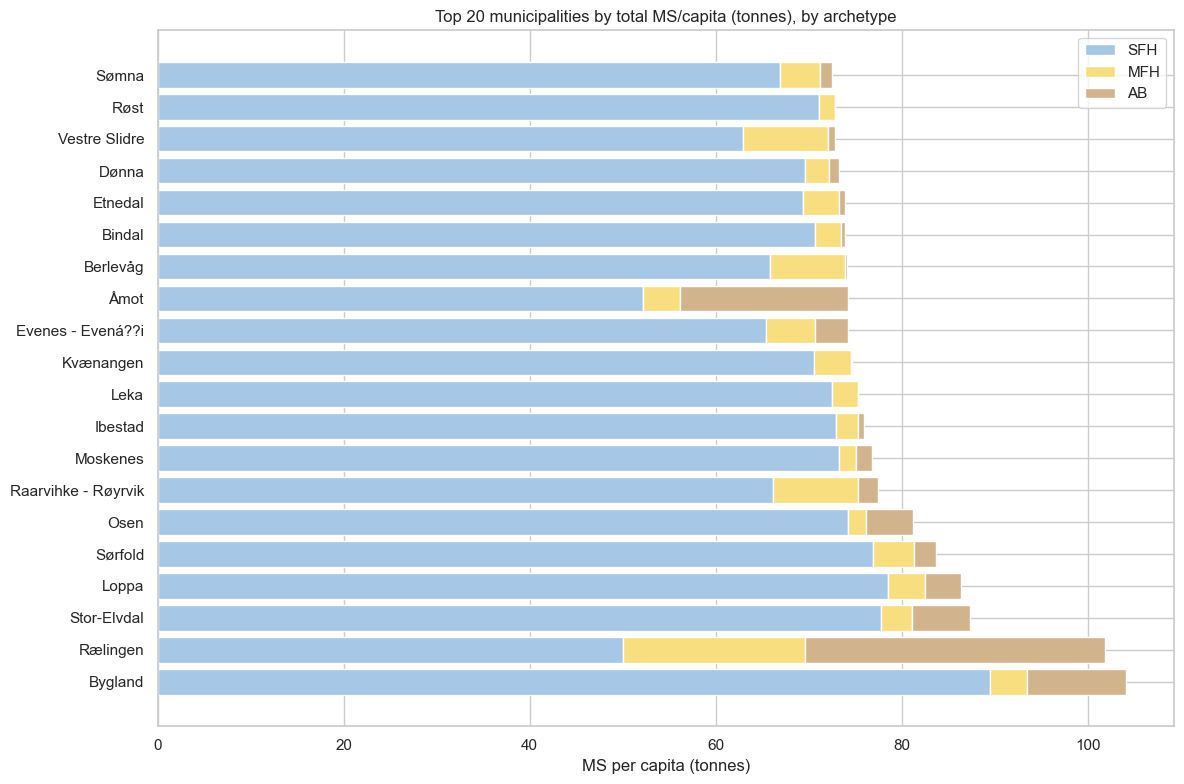

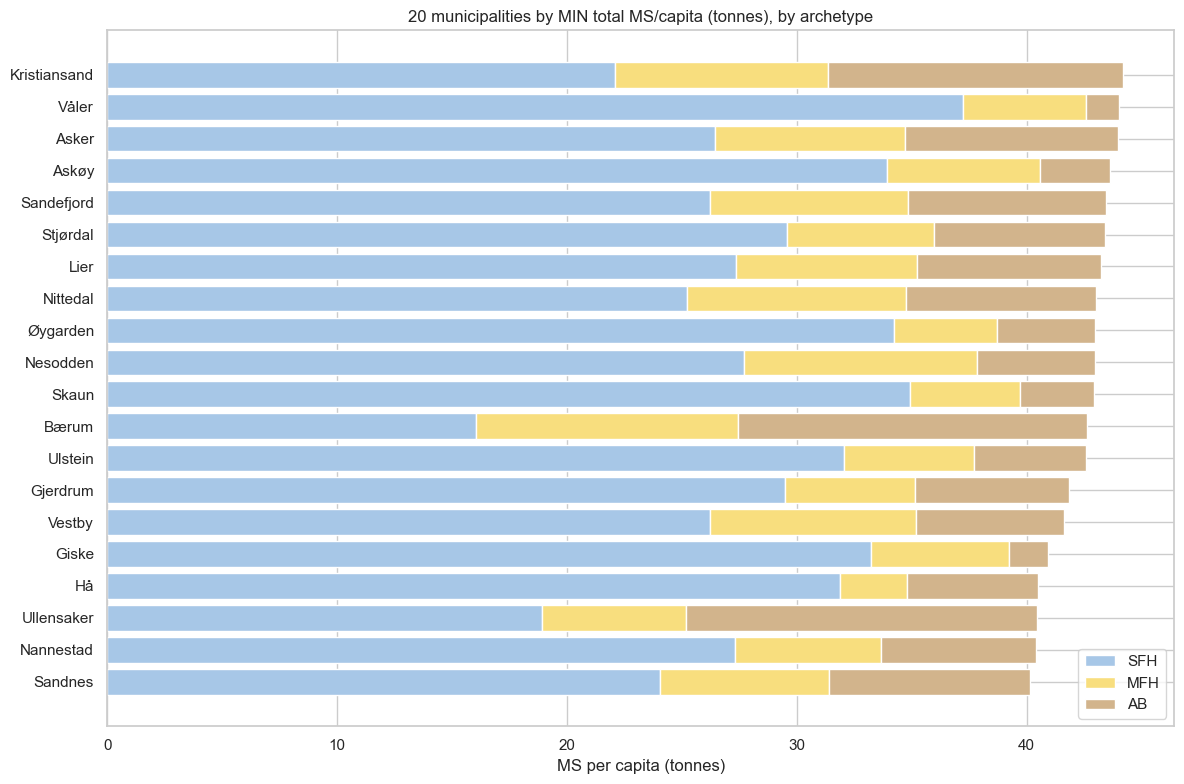

/var/folders/kn/87q7q5h140ldb97ht3jdcpr00000gn/T/ipykernel_78813/1376579056.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oslo_adj["total_ms_per_capita"] = (oslo_adj["SFH_per_capita"] +


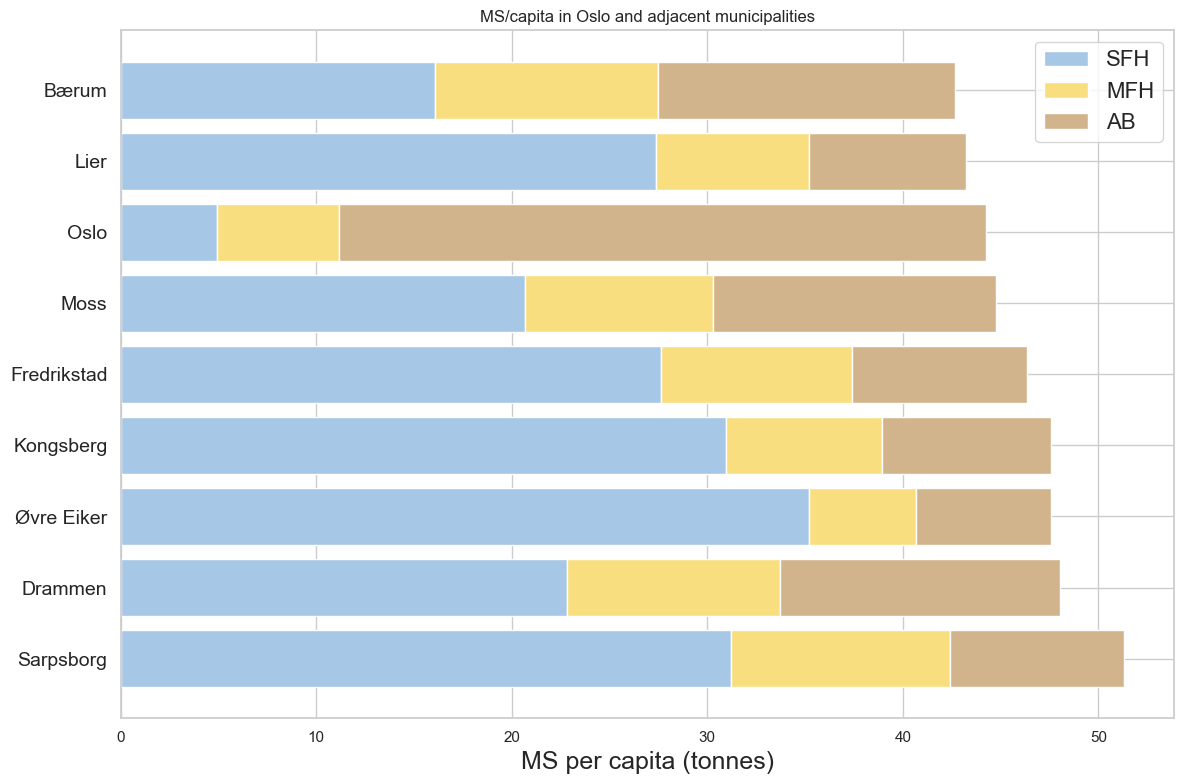

In [52]:
# Standardize column names
mat_stock_approach_2.columns = mat_stock_approach_2.columns.str.lower().str.replace(' ', '_')
municipalities_with_population.columns = municipalities_with_population.columns.str.lower().str.replace(' ', '_')

# Merge datasets
mat_intensity_pop_merge = pd.merge(
    mat_stock_approach_2,
    municipalities_with_population[['kommunenum', 'kommunenav', 'pop_tot']],
    on='kommunenum',
    how='left'
)

TOTAL_data = mat_intensity_pop_merge[mat_intensity_pop_merge["material_type"] == "TOTAL"].drop(columns=["db_area", "db_basement", "db_total"])

summed_data = TOTAL_data.groupby(['kommunenum'], as_index=False).agg({
    'total_material_amounts': 'sum',
    'pop_tot': 'first'
})
summed_data["ms_per_capita"] = summed_data["total_material_amounts"] / summed_data["pop_tot"]

TOTAL_data["type"] = TOTAL_data["archetype"].str.split("_").str[0]
archetype_sums = TOTAL_data.groupby(['kommunenum', 'kommunenav', 'pop_tot', 'type'], as_index=False).agg({
    'total_material_amounts': 'sum'
})
pivot_data = archetype_sums.pivot_table(index=['kommunenum', 'kommunenav', 'pop_tot'], 
                                        columns='type', 
                                        values='total_material_amounts', 
                                        fill_value=0).reset_index()
pivot_data["ms_per_capita"] = pivot_data[['AB', 'MFH', 'SFH']].sum(axis=1) / pivot_data["pop_tot"]
pivot_data["AB_per_capita"] = pivot_data["AB"] / pivot_data["pop_tot"]
pivot_data["MFH_per_capita"] = pivot_data["MFH"] / pivot_data["pop_tot"]
pivot_data["SFH_per_capita"] = pivot_data["SFH"] / pivot_data["pop_tot"]

def plot_municipalities(data, title, ascending):
    selected = data.sort_values(by="ms_per_capita", ascending=ascending).head(20)
    colors = ["#A7C7E7", "#F8DE7E", "#D2B48C"]
    fig, ax = plt.subplots(figsize=(12, 8))
    y_pos = np.arange(len(selected))
    ax.barh(y_pos, selected["SFH_per_capita"] / 1000, color=colors[0], label="SFH")
    ax.barh(y_pos, selected["MFH_per_capita"] / 1000, left=selected["SFH_per_capita"] / 1000,
            color=colors[1], label="MFH")
    ax.barh(y_pos, selected["AB_per_capita"] / 1000, left=(selected["SFH_per_capita"] + selected["MFH_per_capita"]) / 1000,
            color=colors[2], label="AB")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(selected["kommunenav"])
    ax.set_xlabel("MS per capita (tonnes)")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_oslo_and_adjacent(data):
    data["kommunenum"] = data["kommunenum"].astype(str).str.zfill(4)
    oslo_codes = ["0301", "3103", "3105", "3107", "3301", "3303", "3312", "3201", "3314"]
    oslo_adj = data[data["kommunenum"].isin(oslo_codes)]
    oslo_adj["total_ms_per_capita"] = (oslo_adj["SFH_per_capita"] +
                                       oslo_adj["MFH_per_capita"] +
                                       oslo_adj["AB_per_capita"])
    oslo_adj = oslo_adj.sort_values(by="total_ms_per_capita", ascending=False)
    colors = ["#A7C7E7", "#F8DE7E", "#D2B48C"]
    fig, ax = plt.subplots(figsize=(12, 8))
    y_pos = np.arange(len(oslo_adj))
    ax.barh(y_pos, oslo_adj["SFH_per_capita"] / 1000, color=colors[0], label="SFH")
    ax.barh(y_pos, oslo_adj["MFH_per_capita"] / 1000, left=oslo_adj["SFH_per_capita"] / 1000,
            color=colors[1], label="MFH")
    ax.barh(y_pos, oslo_adj["AB_per_capita"] / 1000, left=(oslo_adj["SFH_per_capita"] + oslo_adj["MFH_per_capita"]) / 1000,
            color=colors[2], label="AB")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(oslo_adj["kommunenav"], size=14)
    ax.set_xlabel("MS per capita (tonnes)", size=18)
    ax.set_title("MS/capita in Oslo and adjacent municipalities")
    ax.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

plot_municipalities(pivot_data, "Top 20 municipalities by total MS/capita (tonnes), by archetype", ascending=False)
plot_municipalities(pivot_data, "20 municipalities by MIN total MS/capita (tonnes), by archetype", ascending=True)
plot_oslo_and_adjacent(pivot_data)


## Monte Carlo

### Material inventory

In [6]:
# ----------------------------
# 1. Data Preparation
# ----------------------------
np.random.seed(42)  # For reproducibility

# Assume material_inventory_df is already loaded.
# Rename "Value" to "average" and split the "Archetype" column into "type" and "cohort".
material_inventory_data = material_inventory_df.rename(columns={'Value': 'average'})
material_inventory_data[['type', 'cohort']] = material_inventory_data['Archetype'].str.split('_', n=1, expand=True)

print("DataFrame after splitting 'Archetype' into 'type' and 'cohort':")
print(material_inventory_data)
print("-" * 60)

# ----------------------------
# 2. Monte Carlo Simulation (Vectorized per Group)
# ----------------------------
num_simulations = 10  # Number of simulation runs

# Gather the universal unique values for each categorical field.
unique_types    = np.sort(material_inventory_data['type'].unique())
unique_cohorts  = np.sort(material_inventory_data['cohort'].unique())
unique_materials = np.sort(material_inventory_data['Material type'].unique())
# (Make sure that "TOTAL" is one of the unique materials.)

n_types    = len(unique_types)
n_cohorts  = len(unique_cohorts)
n_materials = len(unique_materials)

# Create a mapping from category to index for quick lookup.
type_to_index    = {t: i for i, t in enumerate(unique_types)}
cohort_to_index  = {c: i for i, c in enumerate(unique_cohorts)}
material_to_index = {m: i for i, m in enumerate(unique_materials)}

# Pre-allocate the final 4-D array for simulation results (dimensions: type, cohort, material, sim_run)
material_inventory_array = np.full((n_types, n_cohorts, n_materials, num_simulations), np.nan, dtype=float)

# Group the DataFrame by (type, cohort)
grouped = material_inventory_data.groupby(['type', 'cohort'])
for (grp_type, grp_cohort), group_df in grouped:
    i = type_to_index[grp_type]
    j = cohort_to_index[grp_cohort]
    
    # Get the TOTAL row (if present) which gives the "original total" value.
    total_row = group_df[group_df['Material type'] == 'TOTAL']
    if not total_row.empty:
        tot_orig = total_row['average'].values[0]
    else:
        # If no TOTAL row exists, use the sum of all rows in the group.
        tot_orig = group_df['average'].sum()
        
    # Set up the triangular distribution parameters based on tot_orig.
    lower = tot_orig * 0.9
    mode  = tot_orig
    upper = tot_orig * 1.1
    # Generate simulated total values (vectorized for num_simulations)
    simulated_totals = np.random.triangular(lower, mode, upper, num_simulations)  # Shape: (num_simulations,)
    
    # For non-TOTAL materials, we compute the allocation by share.
    non_total_df = group_df[group_df['Material type'] != 'TOTAL']
    if not non_total_df.empty:
        # Compute shares for each material in this group.
        shares = non_total_df['average'].values.astype(float) / tot_orig  # Shape: (n_non_total,)
        # Compute simulated values all at once using an outer product.
        # Resulting shape: (n_non_total, num_simulations)
        sim_values = np.outer(shares, simulated_totals)
        
        # Fill in the simulation results for each non-TOTAL material.
        # It is important to reset the index to ensure we iterate from 0.
        non_total_df = non_total_df.reset_index(drop=True)
        for r in range(len(non_total_df)):
            material_name = non_total_df.loc[r, 'Material type']
            k = material_to_index[material_name]
            material_inventory_array[i, j, k, :] = sim_values[r, :]
    
    # For the TOTAL row, store the simulated total directly.
    if not total_row.empty:
        k = material_to_index['TOTAL']
        material_inventory_array[i, j, k, :] = simulated_totals
    # (If there is no TOTAL row, you can choose whether to leave the array as NaN or fill it.)

# ----------------------------
# 3. Example Query and Output
# ----------------------------
print("Unique types:", unique_types)
print("Unique cohorts:", unique_cohorts)
print("Unique materials:", unique_materials)
print("-" * 60)
print("Material inventory array shape:", material_inventory_array.shape)

# For example, retrieve simulation values for the first type, first cohort, and material "Concrete" (if present).
material_name_query = "concrete"  # adjust the case as needed
if material_name_query in material_to_index:
    idx_material = material_to_index[material_name_query]
    sim_vals = material_inventory_array[0, 0, idx_material, :]
    print(f"Simulated values for {unique_types[0]} / {unique_cohorts[0]} / {material_name_query}:")
    print(sim_vals)
else:
    print(f"Material '{material_name_query}' not found in the data.")

# Now, material_inventory_array is fully built in a vectorized manner and ready for further multiplications.


DataFrame after splitting 'Archetype' into 'type' and 'cohort':
    Archetype             Material type        average type cohort
0     AB_1955                    cement  124669.718274   AB   1955
1     AB_1955                  concrete  464048.503418   AB   1955
2     AB_1955        concrete surrogate  332089.134720   AB   1955
3     AB_1955  construction grade steel   22167.514520   AB   1955
4     AB_1955                     glass    2697.149572   AB   1955
..        ...                       ...            ...  ...    ...
243  MFH_2021                     other       2.030670  MFH   2021
244  MFH_2021    wood and wood products   70966.022483  MFH   2021
245  MFH_2021            wood surrogate    4614.782720  MFH   2021
246  MFH_2021       paper and cardboard   11872.785156  MFH   2021
247  MFH_2021                     TOTAL  207026.687167  MFH   2021

[248 rows x 5 columns]
------------------------------------------------------------
Unique types: ['AB' 'MFH' 'SFH']
Unique cohorts

### Average heated floor area

In [7]:
# -----------------------------
# Settings for simulation:
# Use the triangular distribution with a 10% deviation.
num_simulations = 10

# Prepare a list to hold simulation records.
# Each record will be: (type, cohort, sim_no, sim_value)
final_records = []

# Loop over each column in heated_floor_df (except "Combined")
for col in heated_floor_df.columns:
    if col == "Combined":
        continue

    # Get the base value from row 0 for this archetype column.
    base_val = heated_floor_df[col].iloc[0]
    
    # Set triangular distribution parameters.
    lower = base_val * 0.8
    mode  = base_val
    upper = base_val * 1.2
    
    # Generate simulation values.
    sim_values = np.random.triangular(lower, mode, upper, num_simulations)
    
    # Clean the column name in case there is trailing underscore.
    col_clean = col.rstrip('_')
    # Split into type and cohort (assumes column names are like "AB_1955" or "SFH_1956_1970")
    parts = col_clean.split('_', 1)
    if len(parts) == 2:
        typ, cohort = parts[0], parts[1]
    else:
        typ = col_clean
        cohort = ''
    
    # Record simulation runs.
    for sim_no, sim_val in enumerate(sim_values, start=1):
        final_records.append((typ, cohort, sim_no, sim_val))

# Define the structured array dtype.
final_dtype = [('type', 'U10'),
               ('cohort', 'U30'),
               ('sim_no', 'i4'),
               ('sim_value', 'f8')]

# Convert the list of records to a structured NumPy array.
HFA_array = np.array(final_records, dtype=final_dtype)

# Display the final simulation array.
print("Final simulated array (structure: {type, cohort, sim_no, sim_value}):")
print(HFA_array)


Final simulated array (structure: {type, cohort, sim_no, sim_value}):
[('AB', '1955',  1,  63.3350614 ) ('AB', '1955',  2,  63.80023551)
 ('AB', '1955',  3,  62.57843946) ('AB', '1955',  4,  54.43667031)
 ('AB', '1955',  5,  46.76920186) ('AB', '1955',  6,  62.95931149)
 ('AB', '1955',  7,  55.16449898) ('AB', '1955',  8,  64.30765856)
 ('AB', '1955',  9,  64.17890415) ('AB', '1955', 10,  61.12735743)
 ('AB', '1956_1970',  1,  50.53440563)
 ('AB', '1956_1970',  2,  51.70264272)
 ('AB', '1956_1970',  3,  57.81618057)
 ('AB', '1956_1970',  4,  50.83911802)
 ('AB', '1956_1970',  5,  48.57158084)
 ('AB', '1956_1970',  6,  53.62023947)
 ('AB', '1956_1970',  7,  59.81221712)
 ('AB', '1956_1970',  8,  55.33512347)
 ('AB', '1956_1970',  9,  53.77066361)
 ('AB', '1956_1970', 10,  47.07306128)
 ('AB', '1971_1980',  1,  62.49464392)
 ('AB', '1971_1980',  2,  71.47931121)
 ('AB', '1971_1980',  3,  55.25756995)
 ('AB', '1971_1980',  4,  61.22570966)
 ('AB', '1971_1980',  5,  67.15818041)
 ('AB', '1

### Archetype average areas 

In [8]:
archetype_area_df

,Archetype,DB_Area,DB_Basement,DB_total
0,SFH_1955,219.5,76.0,295.5
1,MFH_1955,296.0,108.1,404.1
2,AB_1955,728.7,155.4,884.1
3,SFH_1956_1970,211.0,73.7,284.7
4,MFH_1956_1970,325.3,118.1,443.4
5,AB_1956_1970,1326.3,277.9,1604.2
6,SFH_1971_1980,215.4,78.2,293.6
7,MFH_1971_1980,326.6,120.6,447.2
8,AB_1971_1980,1763.6,464.0,2227.6
9,SFH_1981_1990,288.6,126.0,414.6


### ODYM-RECC 

### Manufacturing demand

In [9]:
# Data from ODYM-RECC

manufacturing_energy_int = pd.read_excel("/Users/dolgayamaria/Thesis/Practical Part/Data/LCA/4_EI_ManufacturingEnergyIntensity_V2.2.xlsx", sheet_name = "Values_Master")
process_energy_int = pd.read_excel("/Users/dolgayamaria/Thesis/Practical Part/Data/LCA/4_EI_ProcessEnergyIntensity_V3.2.xlsx", sheet_name = "Values_Master")
direct_emissions = pd.read_excel("/Users/dolgayamaria/Thesis/Practical Part/Data/LCA/6_PR_DirectEmissions_V1.2.xlsx", sheet_name = "Values_Master")
process_extentions_materials = pd.read_excel("/Users/dolgayamaria/Thesis/Practical Part/Data/CURRENT_VN1_0_from_Lola/4_PE_ProcessExtensions_Materials_VN1.0.xlsx", sheet_name = "values")


In [10]:
manufacturing_energy_int_copy = manufacturing_energy_int.copy()

manufacturing_energy_int_copy = manufacturing_energy_int_copy[['Manufacturing_i3', 'Energy_Carriers_m6', 'value', 'unit']]

manufacturing_energy_int_copy = manufacturing_energy_int_copy[
    manufacturing_energy_int_copy['Manufacturing_i3'].str.contains('SFH_standard|MFH_standard|RT_standard', case=False, regex=True)
]
manufacturing_energy_int_copy = manufacturing_energy_int_copy.drop_duplicates()

manufacturing_energy_int_copy

,Manufacturing_i3,Energy_Carriers_m6,value,unit
20,manufacturing of SFH_standard,diesel,6.20,MJ/m2
21,manufacturing of SFH_standard,electricity,34.70,MJ/m2
22,manufacturing of SFH_standard,natural gas,20.90,MJ/m2
23,manufacturing of SFH_standard,gasoline,156.20,MJ/m2
35,manufacturing of MFH_standard,diesel,5.00,MJ/m2
36,manufacturing of MFH_standard,electricity,0.36,MJ/m2
37,manufacturing of MFH_standard,gasoline,156.20,MJ/m2
168,manufacturing of RT_standard,diesel,5.00,MJ/m2
169,manufacturing of RT_standard,electricity,0.36,MJ/m2
170,manufacturing of RT_standard,gasoline,156.20,MJ/m2


In [11]:
simulation_runs = 10

# Initialize list for results
results = []

# Group by Manufacturing_i3 so we can work on each manufacturing type separately.
for manufacturing, group in manufacturing_energy_int_copy.groupby("Manufacturing_i3"):
    # Calculate the total for this manufacturing group from the 'value' column.
    total_value = group["value"].sum()
    group = group.copy()
    group["share"] = group["value"] / total_value
    # Simulate total values using a triangular distribution (±10% around the total)
    simulated_totals = np.random.triangular(total_value * 0.9, total_value, total_value * 1.1, simulation_runs)
    
    # Determine the short type name from Manufacturing_i3:
    mfg_lower = manufacturing.lower()
    if "sfh_standard" in mfg_lower:
        mfg_type = "SFH"
    elif "mfh_standard" in mfg_lower:
        mfg_type = "MFH"
    elif "rt_standard" in mfg_lower:
        mfg_type = "AB"
    else:
        mfg_type = manufacturing
        
    # For each simulation run...
    for sim_no in range(simulation_runs):
        sim_total = simulated_totals[sim_no]
        # For each energy carrier, calculate simulated value from share * simulated total.
        for _, row in group.iterrows():
            simulated_value = row["share"] * sim_total
            results.append((mfg_type, row["Energy_Carriers_m6"], sim_no + 1, simulated_value))

# Convert results to a structured NumPy array
dtype = [("type", "U50"), ("energy_carrier", "U50"), ("sim_no", "i4"), ("simulated_value", "f8")]
manufacturing_demand_array = np.array(results, dtype=dtype)

manufacturing_demand_array


array([('MFH', 'diesel',  1,   5.06953434),
       ('MFH', 'electricity',  1,   0.36500647),
       ('MFH', 'gasoline',  1, 158.37225291),
       ('MFH', 'diesel',  2,   5.10996711),
       ('MFH', 'electricity',  2,   0.36791763),
       ('MFH', 'gasoline',  2, 159.63537251),
       ('MFH', 'diesel',  3,   4.97672899),
       ('MFH', 'electricity',  3,   0.35832449),
       ('MFH', 'gasoline',  3, 155.47301373),
       ('MFH', 'diesel',  4,   5.06846673),
       ('MFH', 'electricity',  4,   0.3649296 ),
       ('MFH', 'gasoline',  4, 158.33890076),
       ('MFH', 'diesel',  5,   5.04410216),
       ('MFH', 'electricity',  5,   0.36317536),
       ('MFH', 'gasoline',  5, 157.57775136),
       ('MFH', 'diesel',  6,   5.27769167),
       ('MFH', 'electricity',  6,   0.3799938 ),
       ('MFH', 'gasoline',  6, 164.87508769),
       ('MFH', 'diesel',  7,   4.65074213),
       ('MFH', 'electricity',  7,   0.33485343),
       ('MFH', 'gasoline',  7, 145.28918418),
       ('MFH', 'diesel',  8

### Manufacturing GWP

In [12]:
direct_emissions 

,extensions,energy carrier,value,unit,stats_array_string,comment
0,CO2 emissions per main output,electricity,0.000,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."
1,CO2 emissions per main output,heat,0.000,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."
2,CO2 emissions per main output,"coal, hard coal",0.110,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."
3,CO2 emissions per main output,"coal, lignite",0.110,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."
4,CO2 emissions per main output,coke,0.110,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."
5,CO2 emissions per main output,heavy fuel oil,0.070,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."
6,CO2 emissions per main output,diesel,0.070,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."
7,CO2 emissions per main output,jet fuel,0.070,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."
8,CO2 emissions per main output,gasoline,0.070,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."
9,CO2 emissions per main output,natural gas,0.070,kg/MJ,none,"From Modaresi et al. (DOI 10.1021/es502930w), ..."


In [12]:
def convert_gco2_kwh_to_kgco2_mj(value_gco2_per_kwh):
    # Convert grams to kilograms
    value_kgco2_per_kwh = value_gco2_per_kwh / 1000.0
    
    # 1 kWh = 3.6 MJ
    value_kgco2_per_mj = value_kgco2_per_kwh / 3.6
    
    return value_kgco2_per_mj


gco2_per_kwh = 31 # For Norway from Scarlat et al. 2022
kgco2_per_mj = convert_gco2_kwh_to_kgco2_mj(gco2_per_kwh)
kgco2_per_mj

0.008611111111111111

In [13]:
direct_emissions_reduced = direct_emissions[['energy carrier', 'value', 'unit']].copy()

# Replace the value for the electricity energy carrier with kgco2_per_mj
direct_emissions_reduced.loc[
    direct_emissions_reduced["energy carrier"].str.lower() == "electricity", "value"
] = kgco2_per_mj

# Set simulation parameters
num_simulations = 10
np.random.seed(42)

# List to store simulation results
results = []

for idx, row in direct_emissions_reduced.iterrows():
    base_val = row["value"]
    lower = base_val * 0.9
    mode = base_val
    upper = base_val * 1.1

    # If the parameters are degenerate (or base_val is zero), use a constant simulation
    if np.isclose(lower, mode, rtol=1e-5) or base_val == 0:
        simulated_values = np.full(num_simulations, mode)
    else:
        simulated_values = np.random.triangular(lower, mode, upper, num_simulations)
    
    # For each simulation run, save the result.
    for sim_no, sim_value in enumerate(simulated_values, start=1):
        results.append((row["energy carrier"], sim_no, sim_value))

# Convert results to a structured NumPy array
dtype = [("energy_carrier", "U50"), ("sim_no", "i4"), ("simulated_value", "f8")]
carriers_emissions_array = np.array(results, dtype=dtype)

carriers_emissions_array


array([('electricity',  1, 0.00849529), ('electricity',  2, 0.00920187),
       ('electricity',  3, 0.00884178), ('electricity',  4, 0.00870073),
       ('electricity',  5, 0.00823102), ('electricity',  6, 0.00823098),
       ('electricity',  7, 0.0080435 ), ('electricity',  8, 0.00902673),
       ('electricity',  9, 0.0087031 ), ('electricity', 10, 0.00881424),
       ('heat',  1, 0.        ), ('heat',  2, 0.        ),
       ('heat',  3, 0.        ), ('heat',  4, 0.        ),
       ('heat',  5, 0.        ), ('heat',  6, 0.        ),
       ('heat',  7, 0.        ), ('heat',  8, 0.        ),
       ('heat',  9, 0.        ), ('heat', 10, 0.        ),
       ('coal, hard coal',  1, 0.10123192),
       ('coal, hard coal',  2, 0.11830152),
       ('coal, hard coal',  3, 0.1146322 ),
       ('coal, hard coal',  4, 0.10616841),
       ('coal, hard coal',  5, 0.10563337),
       ('coal, hard coal',  6, 0.10566212),
       ('coal, hard coal',  7, 0.1075806 ),
       ('coal, hard coal',  8, 0

### GWP from materials production

In [14]:
# STEP 1: Prepare the materials data
df = process_extentions_materials.copy()
df = df[['Material_Production_i2', 'Env_midpoints', 2022, 'unit']]
df = df[df['Env_midpoints'] == 'GWP100'].copy()

# STEP 2: Standardize Material_Production_i2 using allowed values from material_inventory_data["Material type"]
allowed_materials = material_inventory_data["Material type"].unique().tolist()
allowed_materials = [x.strip() for x in allowed_materials]
allowed_materials = sorted(allowed_materials, key=lambda x: len(x), reverse=True)

def standardize_material(mat, allowed_materials):
    mat_lower = mat.lower().strip()
    for allowed in allowed_materials:
        if allowed.lower() in mat_lower:
            return allowed
    print(f"Material type '{mat}' not recognized. Skipping.")
    return np.nan

df['Material_Production_i2'] = df['Material_Production_i2'].apply(lambda x: standardize_material(x, allowed_materials))
df = df.dropna(subset=['Material_Production_i2'])

# STEP 3: Simulate the 2022 values with a triangular distribution ±10%
num_simulations = 10
results = []
np.random.seed(42)

for idx, row in df.iterrows():
    base_val = row[2022]
    lower = base_val * 0.9
    mode = base_val
    upper = base_val * 1.1
    if np.isclose(lower, mode, rtol=1e-5):
        sim_values = np.full(num_simulations, mode)
    else:
        sim_values = np.random.triangular(lower, mode, upper, num_simulations)
    mat_type = row['Material_Production_i2']
    for sim_no, sim_val in enumerate(sim_values, start=1):
        results.append((mat_type, sim_no, sim_val))

dtype = [('material', 'U50'), ('sim_no', 'i4'), ('simulated_GWP', 'f8')]
GWP_material_production_array = np.array(results, dtype=dtype)

GWP_material_production_array

Material type 'production of copper electric grade, primary' not recognized. Skipping.
Material type 'production of automotive steel, primary' not recognized. Skipping.
Material type 'production of cast iron, primary' not recognized. Skipping.
Material type 'production of stainless steel, primary' not recognized. Skipping.
Material type 'production of wrought Al, primary' not recognized. Skipping.
Material type 'production of cast Al, primary' not recognized. Skipping.
Material type 'production of zinc, primary' not recognized. Skipping.
Material type 'production of plastics, primary' not recognized. Skipping.
Material type 'production of bricks from clay' not recognized. Skipping.
Material type 'production of bitumen' not recognized. Skipping.


array([('cement',  1, 0.83856701), ('cement',  2, 0.90831333),
       ('cement',  3, 0.87276908), ('cement',  4, 0.85884631),
       ('cement',  5, 0.81248125), ('cement',  6, 0.81247758),
       ('cement',  7, 0.79397082), ('cement',  8, 0.89102552),
       ('cement',  9, 0.85907973), ('cement', 10, 0.87005116),
       ('concrete',  1, 0.00377319), ('concrete',  2, 0.00440942),
       ('concrete',  3, 0.00427265), ('concrete',  4, 0.00395719),
       ('concrete',  5, 0.00393724), ('concrete',  6, 0.00393832),
       ('concrete',  7, 0.00400982), ('concrete',  8, 0.00411028),
       ('concrete',  9, 0.00407108), ('concrete', 10, 0.00400291),
       ('construction grade steel',  1, 2.22616337),
       ('construction grade steel',  2, 2.09620243),
       ('construction grade steel',  3, 2.1481654 ),
       ('construction grade steel',  4, 2.16831842),
       ('construction grade steel',  5, 2.19011324),
       ('construction grade steel',  6, 2.2757954 ),
       ('construction grade stee

In [15]:
# Clean the municicpalitites and rename columns 

# Rename columns: replace "MFH" with "AB" and "TH" with "MFH"
dwellings_prepared.rename(columns=lambda col: col.replace("MFH", "AB").replace("TH", "MFH"), inplace=True)

# Use MunicipalitiesConverter to clean kommunenum in dwellings_prepared
municipality_converter = MunicipalitiesConverter(dwellings_prepared)
dwellings_prepared_cleaned = municipality_converter.clean_municipalities()

dwellings_prepared_cleaned

4,AB_1955,AB_1956_1970,AB_1971_1980,AB_1981_1990,AB_1991_2000,AB_2001_2010,AB_2011_2020,AB_2021,SFH_1955,SFH_1956_1970,...,SFH_2011_2020,SFH_2021,MFH_1955,MFH_1956_1970,MFH_1971_1980,MFH_1981_1990,MFH_1991_2000,MFH_2001_2010,MFH_2011_2020,MFH_2021
kommunenum,,,,,,,,,,,,,,,,,,,,,
3101,802,313,430,155,283,276,413,295,2669,1119,...,664,129,2286,429,281,225,158,473,512,150
3103,651,1573,870,628,682,1198,1833,914,3100,1320,...,423,102,1855,817,1127,718,352,557,555,225
3105,822,744,1314,497,418,641,565,493,4776,2029,...,514,162,3062,1059,942,404,235,670,942,394
3107,835,998,1094,462,421,1183,2485,645,7660,2331,...,1006,184,4427,1042,1169,922,651,1016,1018,217
3110,0,0,0,0,18,24,76,7,590,116,...,286,48,20,7,12,20,27,133,58,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5628,0,0,0,4,7,0,28,0,307,127,...,85,21,17,2,26,25,12,16,68,10
5630,0,0,0,0,0,0,2,0,213,117,...,6,0,64,3,6,8,0,0,8,0
5632,1,0,27,1,12,5,6,0,206,171,...,12,0,32,24,2,36,16,0,2,0


In [16]:
df = dwellings_prepared_cleaned.reset_index()

# Pivot (melt) the dataframe from wide to long format.
melted_dwellings = df.melt(id_vars='kommunenum', var_name='archetype', value_name='count')

# Split the 'archetype_year' column into 'archetype' and 'year'.
# This assumes that the column names follow a pattern like "AB_1955", "SFH_1956_1970", etc.
# If some years are represented as a range, you'll need to adjust how you want to capture them.
# Below, we assume you want the first number (or simply treat the rest as one field).
melted_dwellings[['type', 'cohort']] = melted_dwellings['archetype'].str.split('_', n=1, expand=True)

# Optionally, you can drop the intermediate 'archetype_year' column
melted_dwellings.drop(columns=['archetype'], inplace=True)
melted_dwellings

,kommunenum,count,type,cohort
0,3101,802,AB,1955
1,3103,651,AB,1955
2,3105,822,AB,1955
3,3107,835,AB,1955
4,3110,0,AB,1955
...,...,...,...,...
8563,5628,10,MFH,2021
8564,5630,0,MFH,2021
8565,5632,0,MFH,2021
8566,5634,0,MFH,2021


# 1. Compute total heated area across municipalities using HFA_array and melted_dwellings

In [17]:
# Convert HFA_array to a DataFrame.
hfa_df = pd.DataFrame(HFA_array)

# Merge melted_dwellings with hfa_df on 'type' and 'cohort'
merged_df = pd.merge(melted_dwellings, hfa_df, on=['type', 'cohort'])

# Multiply the 'count' (number of dwellings) with the simulated HFA value to get total HFA
merged_df['total_hfa'] = merged_df['count'] * merged_df['sim_value']

# Select the desired columns:
# Including: type, cohort, kommunenum, sim_no, and the computed total_hfa.
HFA_total_df = merged_df[['type', 'cohort', 'kommunenum', 'sim_no', 'total_hfa']]

# Alternatively, if you prefer a NumPy structured array, you can convert the result:
dtype_final = [('type', 'U10'), ('cohort', 'U30'), ('kommunenum', 'U10'), ('sim_no', 'i4'), ('total_hfa', 'f8')]
HFA_total_array = np.array(HFA_total_df.to_records(index=False), dtype=dtype_final)

# Display the final DataFrame and/or array (choose one as needed)
HFA_total_df


,type,cohort,kommunenum,sim_no,total_hfa
0,AB,1955,3101,1,50794.719245
1,AB,1955,3101,2,51167.788877
2,AB,1955,3101,3,50187.908451
3,AB,1955,3101,4,43658.209591
4,AB,1955,3101,5,37508.899890
...,...,...,...,...,...
85675,MFH,2021,5636,6,0.000000
85676,MFH,2021,5636,7,0.000000
85677,MFH,2021,5636,8,0.000000
85678,MFH,2021,5636,9,0.000000


# 2. Compute material intensity using material_inventory_array and archetype_area_df (from Sara)

In [19]:
# =============================================================================
# Updated Processing for Average Areas Without Simulation Variation
# =============================================================================
# Parameters
num_simulations = 10  # We still want to replicate each DB_Area for 10 simulation runs

# Assume archetype_area_df is already defined with at least the following columns:
#    'Archetype', 'DB_Area', 'DB_Basement', 'DB_total'
# For this task we only use 'Archetype' and 'DB_Area'

# ----------------------------
# 1. Build the Average Area Structured Array using DB_Area directly
# ----------------------------
# Extract the DB_Area values as a NumPy array:
base_vals = archetype_area_df['DB_Area'].values  # shape: (n,)

# Instead of simulating, simply replicate each DB_Area value for each simulation run.
# Create an array of shape (n, num_simulations) by repeating info in the row.
# Every simulation run gets the same DB_Area value.
sim_values = np.tile(base_vals, (num_simulations, 1)).T  # now shape: (n, num_simulations)

# Process the Archetype field:
# Remove any trailing underscores and split Archetype into type and cohort.
# For example, "SFH_1955" becomes type="SFH" and cohort="1955".
archetypes_clean = archetype_area_df['Archetype'].str.rstrip('_')
split_df = archetypes_clean.str.split('_', n=1, expand=True)
types   = split_df[0].values      # e.g., "SFH"
cohorts = split_df[1].values      # e.g., "1955"

# Now build the structured array.
n = len(archetype_area_df)  # number of archetypes
# Repeat each type and cohort value for each simulation run.
final_types   = np.repeat(types, num_simulations)      # shape: (n * num_simulations,)
final_cohorts = np.repeat(cohorts, num_simulations)      # shape: (n * num_simulations,)
# Create simulation numbers (1-indexed) for each row.
sim_nos = np.tile(np.arange(1, num_simulations + 1), n)  # shape: (n * num_simulations,)
# Flatten the sim_values to a 1D array.
final_sim_vals = sim_values.flatten()                  # shape: (n * num_simulations,)

# Define the structured array dtype.
av_dtype = [
    ('type', 'U10'),
    ('cohort', 'U30'),
    ('sim_no', 'i4'),
    ('sim_value', 'f8')
]

# Allocate an empty structured array and assign values.
av_areas_array = np.empty(final_types.shape[0], dtype=av_dtype)
av_areas_array['type'] = final_types
av_areas_array['cohort'] = final_cohorts
av_areas_array['sim_no'] = sim_nos
av_areas_array['sim_value'] = final_sim_vals


# =============================================================================
# 2. Convert av_areas_array into a 3-D Array and Compute Material Intensity
# =============================================================================
# Convert the structured array to a DataFrame for convenience.
av_df = pd.DataFrame(av_areas_array)
unique_types_av = np.sort(av_df['type'].unique())
unique_cohorts_av = np.sort(av_df['cohort'].unique())

n_types_av = len(unique_types_av)
n_cohorts_av = len(unique_cohorts_av)

# Allocate a new 3-D array with shape (n_types, n_cohorts, num_simulations)
av_areas_3d = np.empty((n_types_av, n_cohorts_av, num_simulations), dtype=float)

# Fill the 3-D array with sim_value, matching by type and cohort
for rec in av_areas_array:
    i = np.where(unique_types_av == rec['type'])[0][0]
    j = np.where(unique_cohorts_av == rec['cohort'])[0][0]
    sim_index = rec['sim_no'] - 1  # convert 1-indexed sim_no to 0-indexed
    av_areas_3d[i, j, sim_index] = rec['sim_value']

# Expected shape: (number of unique types, number of unique cohorts, 10)

# ------------------------------------------------------------------------------
# 3. Compute Material Intensity by Broadcasted Division
# ------------------------------------------------------------------------------
# The material_inventory_array is assumed to have shape:
#      (n_types, n_cohorts, n_materials, num_simulations)
#
# We divide material_inventory_array (which holds a 'count' or similar per municipality)
# by the DB_Area value for each type/cohort/simulation.
#
# To broadcast the division over the material dimension, we reshape av_areas_3d to:
#      (n_types, n_cohorts, 1, num_simulations)
material_intensity_array = material_inventory_array / av_areas_3d[:, :, None, :]

# ------------------------------------------------------------------------------
# 4. Build a Tidy DataFrame with Material Intensity Values
# ------------------------------------------------------------------------------
n_types, n_cohorts, n_materials, _ = material_inventory_array.shape

# It is assumed that unique_materials is already defined (one per material dimension).
# For demonstration, you might have:
# unique_materials = np.array(["Material_{}".format(i) for i in range(n_materials)])
#
# Now, build records for each simulation run.
records = []
for i, typ in enumerate(unique_types_av):
    for j, coh in enumerate(unique_cohorts_av):
        for k in range(n_materials):
            for sim_no in range(num_simulations):
                intensity = material_intensity_array[i, j, k, sim_no]
                material_name = unique_materials[k]  # unique_materials should exist
                records.append((typ, coh, material_name, sim_no + 1, intensity))

df_columns = ['type', 'cohort', 'material', 'sim_no', 'material_intensity']
material_intensity_df = pd.DataFrame(records, columns=df_columns)

material_intensity_df


,type,cohort,material,sim_no,material_intensity
0,AB,1955,TOTAL,1,1413.370895
1,AB,1955,TOTAL,2,1530.925512
2,AB,1955,TOTAL,3,1471.017107
3,AB,1955,TOTAL,4,1447.550836
4,AB,1955,TOTAL,5,1369.404405
...,...,...,...,...,...
2635,SFH,2021,wood surrogate,6,11.835240
2636,SFH,2021,wood surrogate,7,11.251739
2637,SFH,2021,wood surrogate,8,10.641409
2638,SFH,2021,wood surrogate,9,11.723284


# 3. Compute total material stock using material_intensity_df and hfa_total_df

In [20]:
# ----------------------------
# 1. Merge the DataFrames
# ----------------------------
# Both DataFrames share common fields: 'type', 'cohort', 'sim_no'.
# The merge replicates each material intensity row for each municipality (kommunenum) 
# available in HFA_total_df.
merged_df = pd.merge(material_intensity_df, HFA_total_df, on=['type', 'cohort', 'sim_no'], how='inner')

# ----------------------------
# 2. Compute the Material Stock
# ----------------------------
# The material stock is computed as:
#     material_stock = material_intensity * total_hfa
merged_df['material_stock'] = merged_df['material_intensity'] * merged_df['total_hfa']

# ----------------------------
# 3. Select the Desired Columns 
# ----------------------------
material_stock_df = merged_df[['type', 'cohort', 'material', 'kommunenum', 'sim_no', 'material_stock']]

# ----------------------------
# 4. (Optional) Convert to a NumPy Structured Array
# ----------------------------
final_dtype = [
    ('type', 'U10'),
    ('cohort', 'U30'),
    ('material', 'U30'),
    ('kommunenum', 'U10'),
    ('sim_no', 'i4'),
    ('material_stock', 'f8')
]

material_stock_array = np.array(material_stock_df.to_records(index=False), dtype=final_dtype)

material_stock_df


,type,cohort,material,kommunenum,sim_no,material_stock
0,AB,1955,TOTAL,3101,1,7.179178e+07
1,AB,1955,TOTAL,3103,1,5.827487e+07
2,AB,1955,TOTAL,3105,1,7.358210e+07
3,AB,1955,TOTAL,3107,1,7.474580e+07
4,AB,1955,TOTAL,3110,1,0.000000e+00
...,...,...,...,...,...,...
942475,SFH,2021,wood surrogate,5628,10,3.746374e+04
942476,SFH,2021,wood surrogate,5630,10,0.000000e+00
942477,SFH,2021,wood surrogate,5632,10,0.000000e+00
942478,SFH,2021,wood surrogate,5634,10,5.351963e+03


# 4. Compute GWP from material production by using GWP_material_production_array and material_stock_df

In [21]:

# ------------------------------------------------------------------------------
# 1. Convert GWP_material_production_array to a DataFrame
# ------------------------------------------------------------------------------
gwp_df = pd.DataFrame(GWP_material_production_array)
# gwp_df has columns: 'material', 'sim_no', 'simulated_GWP'

# ------------------------------------------------------------------------------
# 2. Augment gwp_df to include surrogate materials if missing
# ------------------------------------------------------------------------------
# For 'wood surrogate': if not present, duplicate rows where material == 'wood and wood products'
if not (gwp_df['material'].str.lower() == 'wood surrogate').any():
    wood_rows = gwp_df[gwp_df['material'].str.lower() == 'wood and wood products']
    if not wood_rows.empty:
        surrogate_wood = wood_rows.copy()
        surrogate_wood['material'] = 'wood surrogate'
        gwp_df = pd.concat([gwp_df, surrogate_wood], ignore_index=True)

# For 'concrete surrogate': if not present, duplicate rows where material == 'concrete'
if not (gwp_df['material'].str.lower() == 'concrete surrogate').any():
    concrete_rows = gwp_df[gwp_df['material'].str.lower() == 'concrete']
    if not concrete_rows.empty:
        surrogate_concrete = concrete_rows.copy()
        surrogate_concrete['material'] = 'concrete surrogate'
        gwp_df = pd.concat([gwp_df, surrogate_concrete], ignore_index=True)

# ------------------------------------------------------------------------------
# 3. Merge material_stock_df with gwp_df on 'material' and 'sim_no'
# ------------------------------------------------------------------------------
# material_stock_df is assumed to have columns:
# ['type', 'cohort', 'material', 'kommunenum', 'sim_no', 'material_stock']
merged_df = pd.merge(material_stock_df, gwp_df, on=['material', 'sim_no'], how='left')

# ------------------------------------------------------------------------------
# 4. Compute the Emissions per Material
# ------------------------------------------------------------------------------
# For rows where GWP data exists, compute:
merged_df['material_emissions'] = merged_df['material_stock'] * merged_df['simulated_GWP']

# ------------------------------------------------------------------------------
# 5. Compute Aggregate (TOTAL) Emissions per Group (per simulation run)
# ------------------------------------------------------------------------------
# For each combination of type, cohort, kommunenum, and sim_no, sum the individual emissions.
group_cols = ['type', 'cohort', 'kommunenum', 'sim_no']
agg_total = merged_df.groupby(group_cols)['material_emissions'].sum().reset_index()
agg_total['material'] = 'TOTAL'

# ------------------------------------------------------------------------------
# 6. Build the Final Dataset Without Removing Individual Rows
# ------------------------------------------------------------------------------
# Remove any existing rows for material == "TOTAL" from merged_df (if any) to avoid duplication.
indiv_df = merged_df[merged_df['material'] != 'TOTAL'].copy()

# Concatenate the individual rows with the aggregated TOTAL rows.
material_stock_emissions_df = pd.concat([indiv_df, agg_total], ignore_index=True)

# Arrange the final columns in a logical order.
material_stock_emissions_df = material_stock_emissions_df[
    ['type', 'cohort', 'material', 'kommunenum', 'sim_no', 'material_emissions']
]

# At this point, material_stock_emissions_df has one row per simulation run (sim_no) for each
# combination of type, cohort, material, and kommunenum. For each simulation run (sim_no),
# there is a row for an individual material (e.g. wood, wood surrogate, concrete, etc.)
# and a row for TOTAL (the sum over all materials).

# ------------------------------------------------------------------------------
# 7. Aggregate Over Simulation Runs to Compute Summary Statistics
# ------------------------------------------------------------------------------
# For each unique combination of type, cohort, material, and kommunenum (ignoring sim_no),
# we now want to store aggregated statistics over the 10 simulation runs.
ms_agg_stats_df = material_stock_emissions_df.groupby(
    ['type', 'cohort', 'material', 'kommunenum'], as_index=False
).agg(
    material_emissions_mean=('material_emissions', 'mean'),
    material_emissions_min=('material_emissions', 'min'),
    material_emissions_max=('material_emissions', 'max'),
    material_emissions_std=('material_emissions', 'std'),
    material_emissions_p5 = ('material_emissions', lambda x: np.percentile(x, 5)),
    material_emissions_p95 = ('material_emissions', lambda x: np.percentile(x, 95))
)

ms_agg_stats_df['material_emissions_std_pct'] = (
    ms_agg_stats_df['material_emissions_std'] / ms_agg_stats_df['material_emissions_mean']
) * 100


ms_agg_stats_df = ms_agg_stats_df.fillna(0)
# ------------------------------------------------------------------------------
# 8. (Optional) Convert the Aggregated DataFrame to a NumPy Structured Array
# ------------------------------------------------------------------------------
final_dtype = [
    ('type', 'U10'),
    ('cohort', 'U30'),
    ('material', 'U30'),
    ('kommunenum', 'U10'),
    ('material_emissions_mean', 'f8'),
    ('material_emissions_min', 'f8'),
    ('material_emissions_max', 'f8'),
    ('material_emissions_std', 'f8'),
    ('material_emissions_std_pct', 'f8'),
    ('material_emissions_p5', 'f8'),
    ('material_emissions_p95', 'f8')
]
material_emissions_stats_array = np.array(ms_agg_stats_df.to_records(index=False), dtype=final_dtype)

ms_agg_stats_df

,type,cohort,material,kommunenum,material_emissions_mean,material_emissions_min,material_emissions_max,material_emissions_std,material_emissions_p5,material_emissions_p95,material_emissions_std_pct
0,AB,1955,TOTAL,0301,1.702160e+09,1.236107e+09,1.984779e+09,2.426941e+08,1.301872e+09,1.973065e+09,14.258008
1,AB,1955,TOTAL,1101,1.007809e+05,7.318699e+04,1.175141e+05,1.436934e+04,7.708076e+04,1.168205e+05,14.258008
2,AB,1955,TOTAL,1103,2.603026e+07,1.890315e+07,3.035220e+07,3.711396e+06,1.990886e+07,3.017306e+07,14.258008
3,AB,1955,TOTAL,1106,6.493167e+06,4.715333e+06,7.571263e+06,9.257963e+05,4.966203e+06,7.526577e+06,14.258008
4,AB,1955,TOTAL,1108,3.239385e+06,2.352439e+06,3.777238e+06,4.618718e+05,2.477596e+06,3.754944e+06,14.258008
...,...,...,...,...,...,...,...,...,...,...,...
94243,SFH,2021,wood surrogate,5628,4.689179e+03,3.856518e+03,5.523033e+03,5.486330e+02,3.977651e+03,5.461962e+03,11.699978
94244,SFH,2021,wood surrogate,5630,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
94245,SFH,2021,wood surrogate,5632,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
94246,SFH,2021,wood surrogate,5634,6.698828e+02,5.509311e+02,7.890047e+02,7.837614e+01,5.682358e+02,7.802803e+02,11.699978


In [38]:
material_stock_emissions_df

,type,cohort,material,kommunenum,sim_no,material_emissions
0,AB,1955,cement,3101,1,7.189313e+06
1,AB,1955,cement,3103,1,5.835714e+06
2,AB,1955,cement,3105,1,7.368598e+06
3,AB,1955,cement,3107,1,7.485133e+06
4,AB,1955,cement,3110,1,0.000000e+00
...,...,...,...,...,...,...
942475,SFH,2021,TOTAL,5636,6,4.128559e+04
942476,SFH,2021,TOTAL,5636,7,3.541077e+04
942477,SFH,2021,TOTAL,5636,8,3.096040e+04
942478,SFH,2021,TOTAL,5636,9,3.670634e+04


# 5. Compute GWP from manufacturing using manufacturing_demand_array and carriers_emissions_array

In [28]:
# Convert manufacturing_demand_array to DataFrame and rename simulated_value to demand_value.
manufacturing_df = pd.DataFrame(manufacturing_demand_array)
manufacturing_df = manufacturing_df.rename(columns={'simulated_value': 'demand_value'})
# manufacturing_df now has columns: type, energy_carrier, sim_no, demand_value

# Convert carriers_emissions_array to DataFrame and rename simulated_value to emission_factor.
carriers_df = pd.DataFrame(carriers_emissions_array)
carriers_df = carriers_df.rename(columns={'simulated_value': 'emission_factor'})
# carriers_df now has columns: energy_carrier, sim_no, emission_factor

# Merge the two DataFrames on 'energy_carrier' and 'sim_no'
gwp_df = pd.merge(manufacturing_df, carriers_df, on=['energy_carrier', 'sim_no'], how='inner')

# Compute the GWP for each entry
gwp_df['gwp_value'] = gwp_df['demand_value'] * gwp_df['emission_factor']

# Select only the desired columns (excluding any totals for now)
GWP_manufacturing_df = gwp_df[['type', 'energy_carrier', 'sim_no', 'gwp_value']]

# Optionally, convert the DataFrame to a structured NumPy array, if needed.
final_dtype = [
    ('type', 'U50'),
    ('energy_carrier', 'U50'),
    ('sim_no', 'i4'),
    ('gwp_value', 'f8')
]
GWP_manufacturing_array = np.array(GWP_manufacturing_df.to_records(index=False), dtype=final_dtype)

GWP_manufacturing_df

,type,energy_carrier,sim_no,gwp_value
0,MFH,diesel,1,0.381602
1,AB,diesel,1,0.374660
2,SFH,diesel,1,0.477105
3,MFH,electricity,1,0.003101
4,AB,electricity,1,0.003044
...,...,...,...,...
95,SFH,natural gas,6,1.373035
96,SFH,natural gas,7,1.588502
97,SFH,natural gas,8,1.544760
98,SFH,natural gas,9,1.645006


# 6. Compute manufacturing emissions using GWP_manufacturing_df and HFA_total_df

In [23]:
merged_manufacturing = pd.merge(HFA_total_df, GWP_manufacturing_df, on=['type', 'sim_no'], how='inner')

# The merged DataFrame now has columns:
#   type, cohort, kommunenum, sim_no, total_hfa, energy_carrier, gwp_value

# Step 2: Compute the manufacturing emissions per row.
# Multiply the total heated area by the emission factor:
merged_manufacturing['manufacturing_emissions'] = merged_manufacturing['total_hfa'] * merged_manufacturing['gwp_value']

# Select only the desired columns:
manufacturing_emissions_df = merged_manufacturing[['type', 'cohort', 'kommunenum', 'energy_carrier', 'sim_no', 'manufacturing_emissions']]


# Step 3: Compute Aggregated TOTAL Emissions per Simulation Run.
# For each unique combination of type, cohort, kommunenum, and sim_no,
# sum the manufacturing_emissions over all energy carriers.
total_emissions = manufacturing_emissions_df.groupby(
    ['type', 'cohort', 'kommunenum', 'sim_no'], as_index=False
)['manufacturing_emissions'].sum()

# Mark these as TOTAL rows.
total_emissions['energy_carrier'] = 'TOTAL'
total_emissions = total_emissions[['type', 'cohort', 'kommunenum', 'energy_carrier', 'sim_no', 'manufacturing_emissions']]

# Step 4: Append the TOTAL rows to the individual energy carrier rows.
final_manufacturing_emissions_df = pd.concat([manufacturing_emissions_df, total_emissions], ignore_index=True)

# (Optional) Sort the final DataFrame for clarity.
final_manufacturing_emissions_df = final_manufacturing_emissions_df.sort_values(
    by=['type', 'cohort', 'kommunenum', 'sim_no', 'energy_carrier']
).reset_index(drop=True)

# ==============================================================================
# Now, Aggregate Over the 10 Simulation Runs
# ==============================================================================
# For each unique combination of type, cohort, kommunenum, and energy_carrier (including TOTAL),
# compute summary statistics across all simulation runs:
#   - manufacturing_emissions_mean
#   - manufacturing_emissions_min
#   - manufacturing_emissions_max
#   - manufacturing_emissions_p5   (5th percentile)
#   - manufacturing_emissions_p95  (95th percentile)
manufacturing_agg_df = final_manufacturing_emissions_df.groupby(
    ['type', 'cohort', 'kommunenum', 'energy_carrier'], as_index=False
).agg(
    manufacturing_emissions_mean = ('manufacturing_emissions', 'mean'),
    manufacturing_emissions_min  = ('manufacturing_emissions', 'min'),
    manufacturing_emissions_max  = ('manufacturing_emissions', 'max'),
    manufacturing_emissions_std  = ('manufacturing_emissions', 'std'),
    manufacturing_emissions_p5   = ('manufacturing_emissions', lambda x: np.percentile(x, 5)),
    manufacturing_emissions_p95  = ('manufacturing_emissions', lambda x: np.percentile(x, 95))
)

manufacturing_agg_df['manufacturing_emissions_std_pct'] = (
    manufacturing_agg_df['manufacturing_emissions_std'] / manufacturing_agg_df['manufacturing_emissions_mean']
) * 100

manufacturing_agg_df = manufacturing_agg_df.fillna(0)
# ==============================================================================
# (Optional) Convert the Aggregated DataFrame to a NumPy Structured Array
# ==============================================================================
final_dtype = [
    ('type', 'U50'),
    ('cohort', 'U30'),
    ('kommunenum', 'U10'),
    ('energy_carrier', 'U50'),
    ('manufacturing_emissions_mean', 'f8'),
    ('manufacturing_emissions_min', 'f8'),
    ('manufacturing_emissions_max', 'f8'),
    ('manufacturing_emissions_std', 'f8'),
    ('manufacturing_emissions_std_pct', 'f8'),
    ('manufacturing_emissions_p5', 'f8'),
    ('manufacturing_emissions_p95', 'f8')
]

manufacturing_agg_df

,type,cohort,kommunenum,energy_carrier,manufacturing_emissions_mean,manufacturing_emissions_min,manufacturing_emissions_max,manufacturing_emissions_std,manufacturing_emissions_p5,manufacturing_emissions_p95,manufacturing_emissions_std_pct
0,AB,1955,0301,TOTAL,7.926177e+07,6.361089e+07,9.070001e+07,8.112234e+06,6.765922e+07,8.902592e+07,10.234737
1,AB,1955,0301,diesel,2.512911e+06,1.948046e+06,2.805445e+06,2.933612e+05,2.047597e+06,2.785897e+06,11.674159
2,AB,1955,0301,electricity,2.211803e+04,1.632402e+04,2.561261e+04,3.033420e+03,1.755101e+04,2.547561e+04,13.714697
3,AB,1955,0301,gasoline,7.672674e+07,6.164652e+07,8.801328e+07,7.867743e+06,6.554287e+07,8.627551e+07,10.254238
4,AB,1955,1101,TOTAL,4.692902e+03,3.766250e+03,5.370133e+03,4.803062e+02,4.005942e+03,5.271014e+03,10.234737
...,...,...,...,...,...,...,...,...,...,...,...
37123,SFH,2021,5636,TOTAL,4.247799e+03,3.518489e+03,4.949498e+03,4.475913e+02,3.657739e+03,4.854998e+03,10.537017
37124,SFH,2021,5636,diesel,1.427638e+02,1.301882e+02,1.700504e+02,1.246935e+01,1.306875e+02,1.628607e+02,8.734250
37125,SFH,2021,5636,electricity,9.732699e+01,8.552447e+01,1.074116e+02,6.732165e+00,8.698620e+01,1.058082e+02,6.917059
37126,SFH,2021,5636,gasoline,3.529704e+03,2.880541e+03,4.113547e+03,3.928277e+02,3.003606e+03,4.048716e+03,11.129196


In [37]:
final_manufacturing_emissions_df

,type,cohort,kommunenum,energy_carrier,sim_no,manufacturing_emissions
0,AB,1955,0301,TOTAL,1,8.697982e+07
1,AB,1955,0301,diesel,1,2.805445e+06
2,AB,1955,0301,electricity,1,2.279660e+04
3,AB,1955,0301,gasoline,1,8.415157e+07
4,AB,1955,0301,TOTAL,2,8.323372e+07
...,...,...,...,...,...,...
371275,SFH,2021,5636,TOTAL,10,4.150896e+03
371276,SFH,2021,5636,diesel,10,1.406875e+02
371277,SFH,2021,5636,electricity,10,1.011021e+02
371278,SFH,2021,5636,gasoline,10,3.426865e+03


# 7. Merge the results 

In [47]:
# ------------------------------------------------------------------------------
# 1. Filter for TOTAL rows in each dataset
# ------------------------------------------------------------------------------
# For manufacturing, TOTAL rows are those where energy_carrier == "TOTAL"
manufacturing_TOTAL = final_manufacturing_emissions_df[
    final_manufacturing_emissions_df['energy_carrier'] == 'TOTAL'
].copy()

# For materials, TOTAL rows are those where material == "TOTAL"
materials_TOTAL = material_stock_emissions_df[
    material_stock_emissions_df['material'] == 'TOTAL'
].copy()

# ------------------------------------------------------------------------------
# 2. Merge the filtered datasets on the common keys: type, cohort, kommunenum, sim_no
# ------------------------------------------------------------------------------
merged_emissions_df = pd.merge(
    manufacturing_TOTAL,
    materials_TOTAL,
    on=['type', 'cohort', 'kommunenum', 'sim_no'],
    how='outer'
)

# ------------------------------------------------------------------------------
# 3. Fill missing emission columns with 0
# ------------------------------------------------------------------------------
merged_emissions_df['manufacturing_emissions'] = merged_emissions_df['manufacturing_emissions'].fillna(0)
merged_emissions_df['material_emissions'] = merged_emissions_df['material_emissions'].fillna(0)

# ------------------------------------------------------------------------------
# 4. Create a new column "total_emissions" that is the sum of manufacturing and material emissions
# ------------------------------------------------------------------------------
merged_emissions_df['total_emissions'] = (
    merged_emissions_df['manufacturing_emissions'] + merged_emissions_df['material_emissions']
)

# For clarity, rearrange columns:
final_cols = ['type', 'cohort', 'kommunenum', 'sim_no', 
              'energy_carrier', 'material', 'total_emissions']
merged_emissions_df = merged_emissions_df[final_cols]


# ------------------------------------------------------------------------------
# 5. Aggregate across all simulations to compute summary statistics:
#    total_mean and total_std (as percentage of the mean)
# ------------------------------------------------------------------------------
# Group by type, cohort, and kommunenum to aggregate across simulation runs
summary_df = merged_emissions_df.groupby(['type', 'cohort', 'kommunenum'], as_index=False).agg(
    total_mean = ('total_emissions', 'mean'),
    total_std = ('total_emissions', 'std')
)

# Compute the standard deviation as a percentage of the mean:
summary_df['total_std_pct'] = (summary_df['total_std'] / summary_df['total_mean']) * 100

# Rearrange the output columns:
summary_df = summary_df[['type', 'cohort', 'kommunenum', 'total_mean', 'total_std_pct']]


# =============================================================================
# Dashboard Consideration:
# =============================================================================
# For a dashboard, summary_df is quite relevant because it presents the overall average 
# emissions and its variability per region (type, cohort, kommunenum) in a compact format.
#
# You might also want drill-down tables showing simulation-run details filtered for a
# particular region, or further disaggregation if needed.
# =============================================================================

# ------------------------------------------------------------------------------
# 6. (Optional) Convert the Summary DataFrame to a NumPy Structured Array
# ------------------------------------------------------------------------------
final_dtype = [
    ('type', 'U50'),
    ('cohort', 'U30'),
    ('kommunenum', 'U10'),
    ('total_mean', 'f8'),
    ('total_std_pct', 'f8')
]
summary_array = np.array(summary_df.to_records(index=False), dtype=final_dtype)
summary_df = summary_df.fillna(0)
summary_df

,type,cohort,kommunenum,total_mean,total_std_pct
0,AB,1955,0301,1.781422e+09,13.911464
1,AB,1955,1101,1.054738e+05,13.911464
2,AB,1955,1103,2.724237e+07,13.911464
3,AB,1955,1106,6.795524e+06,13.911464
4,AB,1955,1108,3.390228e+06,13.911464
...,...,...,...,...,...
8563,SFH,2021,5628,4.202626e+05,10.427617
8564,SFH,2021,5630,0.000000e+00,0.000000
8565,SFH,2021,5632,0.000000e+00,0.000000
8566,SFH,2021,5634,6.003751e+04,10.427617


# Plots and dashboards

In [80]:
counties_masks_2024 = gpd.read_file('/Users/dolgayamaria/Thesis/Practical Part/Data/ssb_counties_masks/Fylker 2024.shp')
counties_masks_2024

,fylkesnumm,fylkesnavn,geometry
0,33,Buskerud,"POLYGON ((239209.810 6643061.850, 239211.150 6..."
1,42,Agder,"POLYGON ((136851.642 6458621.767, 131953.860 6..."
2,32,Akershus,"POLYGON ((241604.820 6651210.380, 241606.660 6..."
3,03,Oslo,"POLYGON ((260102.430 6645441.707, 258753.600 6..."
4,56,Finnmark - Finnmárku - Finmarkku,"POLYGON ((802883.080 7924105.776, 808944.430 7..."
5,55,Troms - Romsa - Tromssa,"POLYGON ((598870.299 7775404.581, 599421.310 7..."
6,31,Østfold,"POLYGON ((282859.309 6555776.605, 282859.280 6..."
7,46,Vestland,"POLYGON ((-50700.440 6922738.750, -45998.650 6..."
8,15,Møre og Romsdal,"POLYGON ((199994.690 7009452.890, 200006.390 7..."
9,40,Telemark,"POLYGON ((208120.027 6572323.149, 208178.270 6..."


In [81]:
municipal_masks_2024

,kommunenum,kommunenav,geometry,centroid
0,4216,Birkenes,"POLYGON ((101595.610 6518339.130, 101714.390 6...",POINT (103257.735 6498567.550)
1,5053,Inderøy,"POLYGON ((309171.842 7096129.147, 311210.181 7...",POINT (307007.992 7087056.941)
2,3440,Øyer,"POLYGON ((243262.690 6812689.840, 243274.060 6...",POINT (261119.888 6806582.764)
3,4014,Kragerø,"POLYGON ((181548.000 6546623.340, 181549.370 6...",POINT (186304.659 6531850.948)
4,4226,Hægebostad,"POLYGON ((50960.310 6515113.550, 50967.240 651...",POINT (45677.535 6507723.452)
...,...,...,...,...
352,3305,Ringerike,"POLYGON ((242360.370 6685296.060, 242365.180 6...",POINT (228624.062 6694320.664)
353,5512,Dielddanuorri - Tjeldsund,"POLYGON ((564510.020 7599694.630, 564482.550 7...",POINT (568301.453 7607201.281)
354,4643,Årdal,"POLYGON ((107464.530 6825564.610, 108033.520 6...",POINT (114997.124 6816344.133)
355,3330,Hol,"POLYGON ((139552.880 6733877.850, 139558.550 6...",POINT (117425.256 6735260.621)


In [82]:
counties_coast = gpd.read_file('/Users/dolgayamaria/Thesis/Practical Part/Data/Geopackage/Fylker.gpkg')
counties_coast = counties_coast.rename(columns={"nummer": "fylkesnumm"})
counties_coast = counties_coast.rename(columns={"navn": "fylkesnavn"})
counties_coast

,fylkesnavn,fylkesnumm,geometry
0,Troms,55,"MULTIPOLYGON (((545662.840 7586868.250, 545671..."
1,Buskerud,33,"MULTIPOLYGON (((183975.280 6640519.200, 183137..."
2,Innlandet,34,"MULTIPOLYGON (((228387.880 6732099.410, 228304..."
3,Rogaland,11,"MULTIPOLYGON (((-59009.450 6596082.000, -59028..."
4,Finnmark,56,"MULTIPOLYGON (((784019.300 7797199.080, 784004..."
5,Vestland,46,"MULTIPOLYGON (((-58309.920 6639767.040, -58273..."
6,Vestfold,39,"MULTIPOLYGON (((208737.770 6544299.250, 208740..."
7,Trøndelag,50,"MULTIPOLYGON (((162813.080 7015666.470, 162804..."
8,Agder,42,"MULTIPOLYGON (((22303.360 6462084.930, 22290.9..."
9,Nordland,18,"MULTIPOLYGON (((343669.830 7239794.360, 343660..."


In [83]:
municipalities_coast = gpd.read_file('/Users/dolgayamaria/Thesis/Practical Part/Data/Geopackage/Kommuner.gpkg')
municipalities_coast = municipalities_coast.rename(columns={"nummer": "kommunenum"})
municipalities_coast = municipalities_coast.rename(columns={"navn": "kommunenav"})
municipalities_coast

,kommunenav,kommunenum,geometry
0,Skjervøy,5542,"MULTIPOLYGON (((719880.850 7756195.200, 719863..."
1,Lier,3312,"MULTIPOLYGON (((238005.760 6656465.060, 238831..."
2,Sel,3437,"MULTIPOLYGON (((236815.260 6869436.200, 236508..."
3,Tromsø,5501,"MULTIPOLYGON (((691815.400 7706736.150, 691441..."
4,Time,1121,"MULTIPOLYGON (((-42556.530 6544879.020, -42503..."
...,...,...,...
360,Dielddanuorri,5512,"MULTIPOLYGON (((541886.920 7607612.090, 542096..."
361,Rakkestad,3120,"MULTIPOLYGON (((303793.000 6574028.410, 303706..."
362,Saltdal,1840,"MULTIPOLYGON (((501537.330 7422611.340, 501762..."
363,Malvik,5031,"MULTIPOLYGON (((297741.160 7028485.420, 297405..."


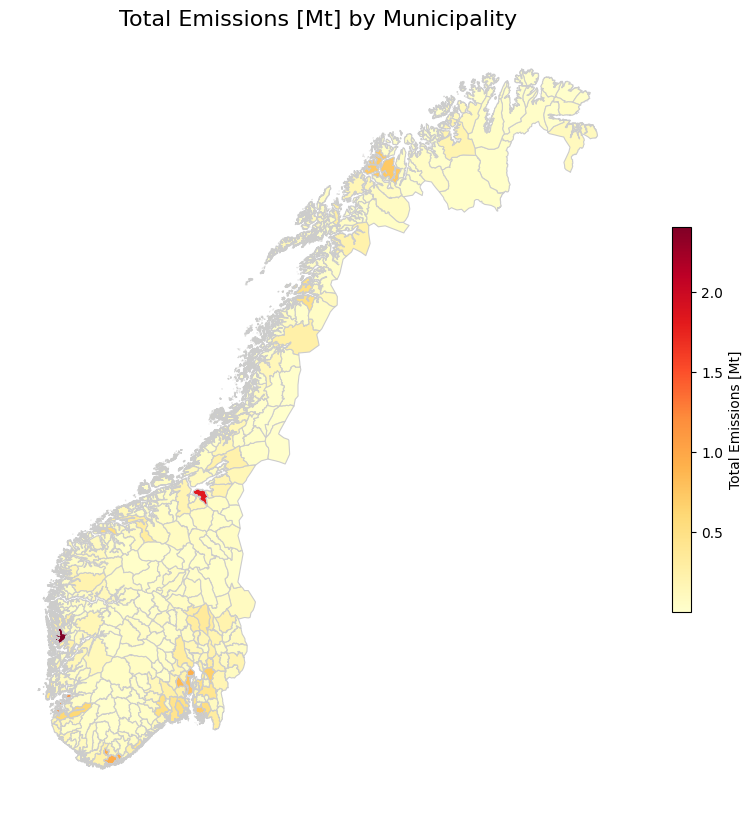

In [95]:
import matplotlib.pyplot as plt

# Ensure the key is a string.
summary_df['kommunenum'] = summary_df['kommunenum'].astype(str)
municipalities_coast['kommunenum'] = municipalities_coast['kommunenum'].astype(str)

# Aggregate total_mean (in kg) by 'kommunenum'
aggregated_df = summary_df.groupby('kommunenum', as_index=False)['total_mean'].sum()

# Merge the aggregated data with the GeoDataFrame.
merged_gdf = municipalities_coast.merge(aggregated_df, on='kommunenum', how='left')

# Create a temporary column for visualization in megatonnes.
merged_gdf['total_mean_Mt'] = merged_gdf['total_mean'] / 1e9

# Plot the map using the megatonnes column.
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

merged_gdf.plot(column='total_mean_Mt',
                cmap='YlOrRd',
                linewidth=0.8,
                ax=ax,
                edgecolor='0.8',
                legend=True,
                legend_kwds={'label': "Total Emissions [Mt]", 'shrink': 0.5})

ax.set_title('Total Emissions [Mt] by Municipality', fontsize=16)
ax.set_axis_off()

# Export the figure as a TIFF file.
plt.savefig('municipal_total_emissions.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()


# Add counties codes to the municipal masks to be able to work with the dashboasd in the efficient way

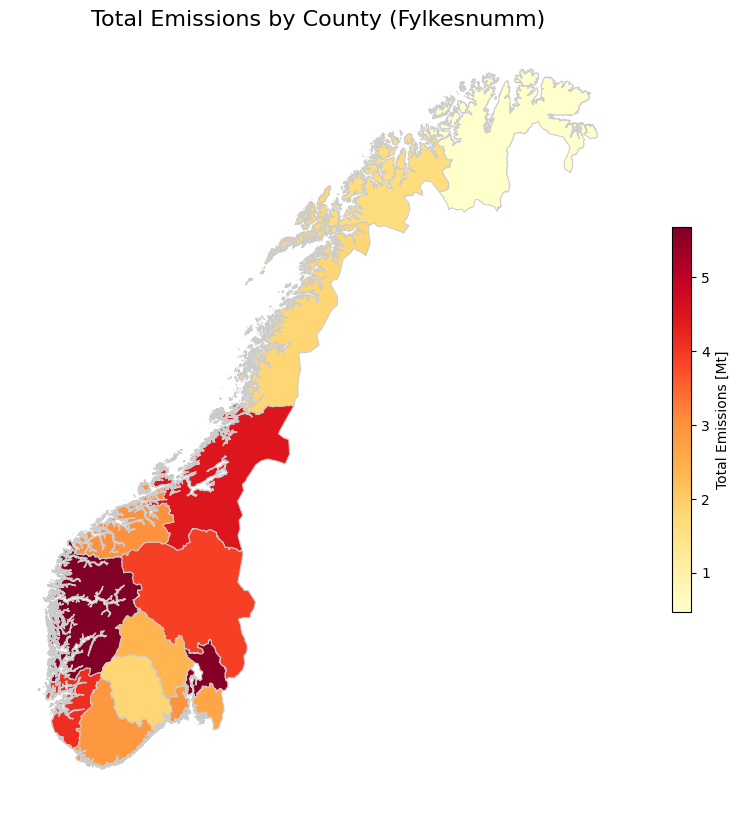

In [96]:
# Ensure both GeoDataFrames use the same CRS.
if municipalities_coast.crs != counties_coast.crs:
    municipalities_coast = municipalities_coast.to_crs(counties_coast.crs)

# Compute centroids for municipalities.
municipalities_coast['centroid'] = municipalities_coast.geometry.centroid
municipal_centroids = municipalities_coast.set_geometry('centroid')

# Spatial join to assign fylkesnumm from counties_coast using the municipality centroids.
municipality_county = gpd.sjoin(
    municipal_centroids, 
    counties_coast[['fylkesnumm', 'geometry']], 
    how='left', 
    predicate='within'
)

# Get a table mapping kommunenum -> fylkesnumm.
mapping_df = municipality_county[['kommunenum', 'fylkesnumm']]

# Merge the mapping with summary_df (which contains only kommunenum).
summary_df['kommunenum'] = summary_df['kommunenum'].astype(str)
mapped_summary = summary_df.merge(mapping_df, on='kommunenum', how='left')

# Aggregate total_mean per fylkesnumm.
aggregated_county = mapped_summary.groupby('fylkesnumm', as_index=False)['total_mean'].sum()

# Merge aggregated values with counties_coast for plotting.
counties_merged = counties_coast.merge(aggregated_county, on='fylkesnumm', how='left')

# Create a temporary column for visualization: convert kg to megatonnes.
counties_merged['total_mean_Mt'] = counties_merged['total_mean'] / 1e9

# Plot and export the choropleth map for county-level totals.
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
counties_merged.plot(
    column='total_mean_Mt',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Total Emissions [Mt]", 'shrink': 0.5}
)
ax.set_title('Total Emissions by County (Fylkesnumm)', fontsize=16)
ax.set_axis_off()

plt.savefig('county_total_emissions.tiff', format='tiff', dpi=300, bbox_inches='tight')


In [ ]:
import dash
from dash import dcc
from dash import html
import geopandas as gpd
import pandas as pd
import plotly.express as px


# Merge datasets on 'kommunenum'
merged_data = municipal_masks_2024.merge(merged_emissions_df, on='kommunenum')

# Convert GeoDataFrame to GeoJSON format
geojson_data = merged_data.__geo_interface__

# Create an interactive choropleth map
fig = px.choropleth_mapbox(
    merged_data,
    geojson=geojson_data,
    locations=merged_data.index,
    color="manufacturing_emissions_mean",
    mapbox_style="carto-positron",
    center={"lat": 39.0, "lon": -8.0},  # adjust as needed for your region
    zoom=5,
    opacity=0.5,
)

# Build Dash app layout
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Energy Carrier Emissions Dashboard"),
    dcc.Graph(figure=fig)
])

if __name__ == '__main__':
    app.run_server(debug=True)


In [27]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 4.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [29]:
!pip install dash_core_components 


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [30]:
! pip install dash_html_components


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
